# Feature Engineering Noteook


## Objectives

- In this notebook we will engineer the features for regression.


## Inputs

- inputs/datasets/cleaning/trainSet.csv
- inputs/datasets/cleaning/testSet.csv

## Outputs

- List the variables that will be engineered.


# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/Heritage-Housing/jupyter_notebooks'

We want to make the child of the current directory the new current directory
* os.chdir() defines the new current directory

In [2]:
import os

os.chdir('/workspaces/Heritage-Housing')
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/Heritage-Housing'

## Load Data

### Training Set

In [4]:
import pandas as pd
%matplotlib inline
train_set_path = "outputs/datasets/cleaned/train_set.csv"
train_set = pd.read_csv(train_set_path)
train_set.head(3)

1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0      1828       0.0           0.0           Av          48          Unf   
1       894       0.0           2.0           No           0          Unf   
2       964       0.0           2.0           No         713          ALQ   

   BsmtUnfSF  GarageArea GarageFinish  GarageYrBlt  ...  KitchenQual LotArea  \
0       1774         774          Unf       2007.0  ...           Gd   11694   
1        894         308          Unf       1962.0  ...           TA    6600   
2        163         432          Unf       1921.0  ...           TA   13360   

   LotFrontage  OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  YearBuilt  \
0         90.0          108            5            9         1822       2007   
1         60.0            0            5            5          894       1962   
2         80.0            0            7            5          876       1921   

   YearRemodAdd  SalePrice  
0          2007     314813  
1          1962     109500  
2          2006     163500  

[3 rows x 21 columns]

### Testing Set

In [5]:
import pandas as pd
test_set_path = "outputs/datasets/cleaned/test_set.csv"
test_set = pd.read_csv(test_set_path)
test_set.head(3)

1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0      2515       0.0           4.0           No        1219          Rec   
1       958     620.0           3.0           No         403          BLQ   
2       979     224.0           3.0           No         185          LwQ   

   BsmtUnfSF  GarageArea GarageFinish  GarageYrBlt  ...  KitchenQual LotArea  \
0        816         484          Unf       1975.0  ...           TA   32668   
1        238         240          Unf       1941.0  ...           Fa    9490   
2        524         352          Unf       1950.0  ...           Gd    7015   

   LotFrontage  OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  YearBuilt  \
0         69.0            0            3            6         2035       1957   
1         79.0            0            7            6          806       1941   
2         69.0            0            4            5          709       1950   

   YearRemodAdd  SalePrice  
0          1975     200624  
1          1950     133000  
2          1950     110000  

[3 rows x 21 columns]

## Data Exploration

We'll generate a Pandas Profiling report to assess whether any further data transformations might be needed. While we don't anticipate major changes since the data has already been cleaned.

In [6]:
from ydata_profiling import ProfileReport
pandas_report = ProfileReport(df=train_set, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Feature Engineering

The main goal is to automate the transformation of variables and help you visually and statistically assess which transformation improves their distribution and suitability for modeling. We will be using the function from feature-engine lesson, and costume to our needs in order to implement the feature engineering process.

In [7]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like pandas-profiling, to evaluate distributions
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        if analysis_type != 'ordinal_encoder':
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=[
                  '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[
                                 f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")

    except Exception:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked

### Categorical Encoding

Categorical feature involves transforming non-numeric variables into a format that can be used in machine learning models. 

Below is the list of categorical variables, we will create a new dataframe for these from the training set.

In [8]:
categorical_variables = list(train_set.select_dtypes(['object','category']).columns)
categorical_variables

['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']

In [9]:
df_category = train_set[categorical_variables].copy()
df_category.head(5)

BsmtExposure BsmtFinType1 GarageFinish KitchenQual
0           Av          Unf          Unf          Gd
1           No          Unf          Unf          TA
2           No          ALQ          Unf          TA
3           No          GLQ          RFn          Gd
4           No          Unf          RFn          Gd

**Apply transformation**

* Variable Analyzed: BsmtExposure
* Applied transformation: ['BsmtExposure_ordinal_encoder'] 



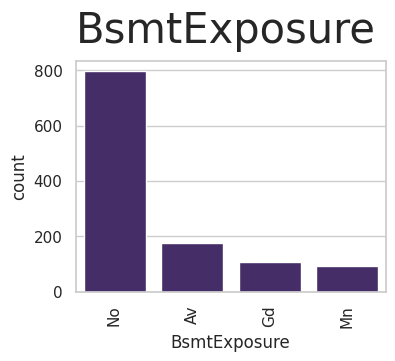

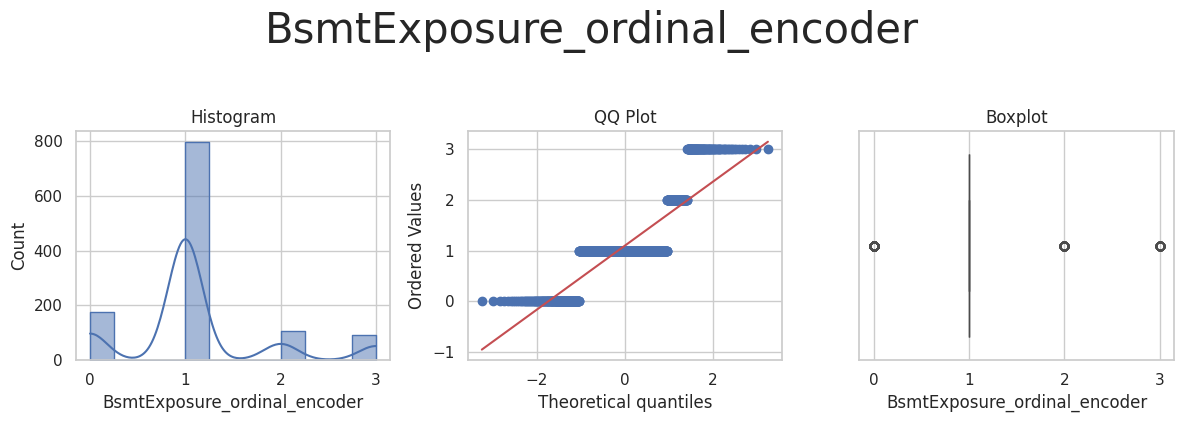



* Variable Analyzed: BsmtFinType1
* Applied transformation: ['BsmtFinType1_ordinal_encoder'] 



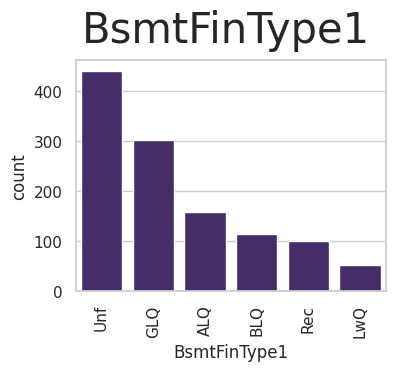

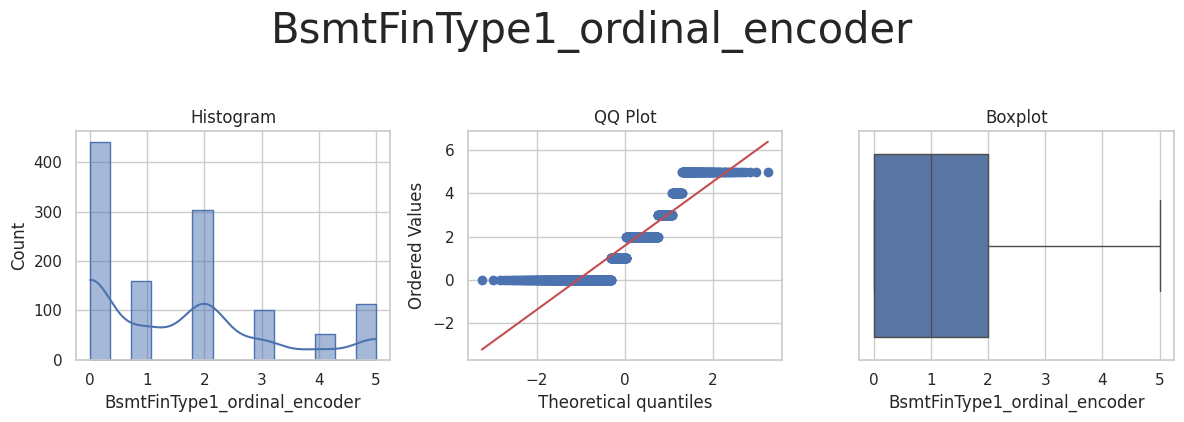



* Variable Analyzed: GarageFinish
* Applied transformation: ['GarageFinish_ordinal_encoder'] 



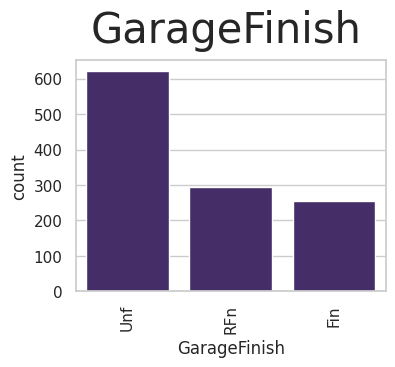

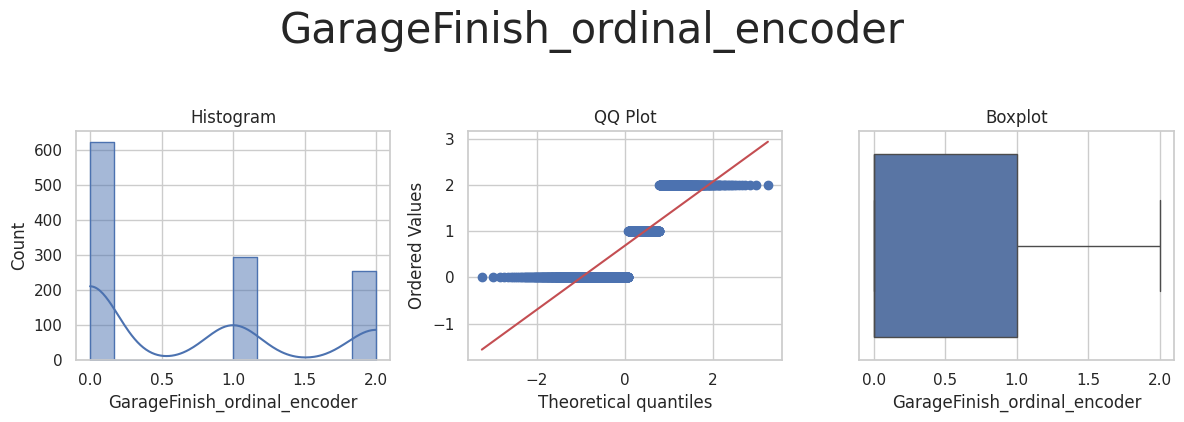



* Variable Analyzed: KitchenQual
* Applied transformation: ['KitchenQual_ordinal_encoder'] 



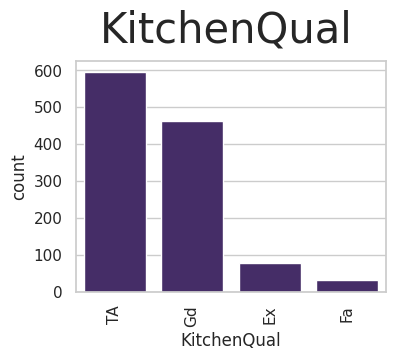

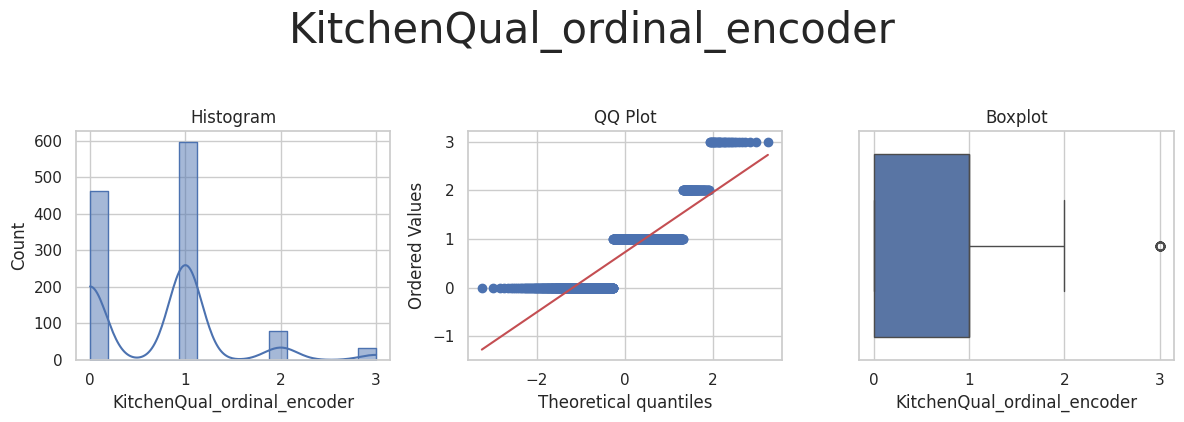

In [10]:
df_category_eng = FeatureEngineeringAnalysis(df=df_category, analysis_type='ordinal_encoder')

In [11]:
encoder = OrdinalEncoder(encoding_method='arbitrary', variables=categorical_variables)
train_set = encoder.fit_transform(train_set)
test_set = encoder.transform(test_set)

print("* Categorical encoding - ordinal transformation done!")

* Categorical encoding - ordinal transformation done!


### Numerical Transformations

Numerical feature involves transforming non-numeric variables into a format that can be used in machine learning models. 

Below is the list of numeric variables, we will create a new dataframe for these from the training set.

In [12]:
numeric_variables = list(train_set.select_dtypes(['int64','float64']).columns)
numeric_variables

['1stFlrSF',
 '2ndFlrSF',
 'BedroomAbvGr',
 'BsmtExposure',
 'BsmtFinSF1',
 'BsmtFinType1',
 'BsmtUnfSF',
 'GarageArea',
 'GarageFinish',
 'GarageYrBlt',
 'GrLivArea',
 'KitchenQual',
 'LotArea',
 'LotFrontage',
 'OpenPorchSF',
 'OverallCond',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd',
 'SalePrice']

In [13]:
df_numeric = train_set[numeric_variables].copy()
df_numeric.head()

1stFlrSF  2ndFlrSF  BedroomAbvGr  BsmtExposure  BsmtFinSF1  BsmtFinType1  \
0      1828       0.0           0.0             0          48             0   
1       894       0.0           2.0             1           0             0   
2       964       0.0           2.0             1         713             1   
3      1689       0.0           3.0             1        1218             2   
4      1541       0.0           3.0             1           0             0   

   BsmtUnfSF  GarageArea  GarageFinish  GarageYrBlt  ...  KitchenQual  \
0       1774         774             0       2007.0  ...            0   
1        894         308             0       1962.0  ...            1   
2        163         432             0       1921.0  ...            1   
3        350         857             1       2002.0  ...            0   
4       1541         843             1       2001.0  ...            0   

   LotArea  LotFrontage  OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  \
0    11694         90.0          108            5            9         1822   
1     6600         60.0            0            5            5          894   
2    13360         80.0            0            7            5          876   
3    13265         69.0           59            5            8         1568   
4    13704        118.0           81            5            7         1541   

   YearBuilt  YearRemodAdd  SalePrice  
0       2007          2007     314813  
1       1962          1962     109500  
2       1921          2006     163500  
3       2002          2002     271000  
4       2001          2002     205000  

[5 rows x 21 columns]

### Apply Transformations

* Variable Analyzed: 1stFlrSF
* Applied transformation: ['1stFlrSF_log_e', '1stFlrSF_log_10', '1stFlrSF_reciprocal', '1stFlrSF_power', '1stFlrSF_box_cox', '1stFlrSF_yeo_johnson'] 



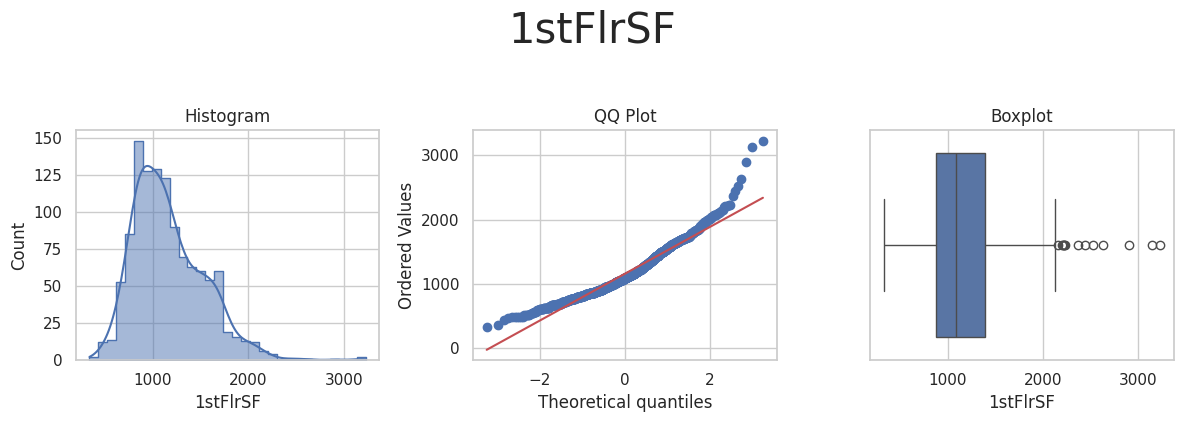

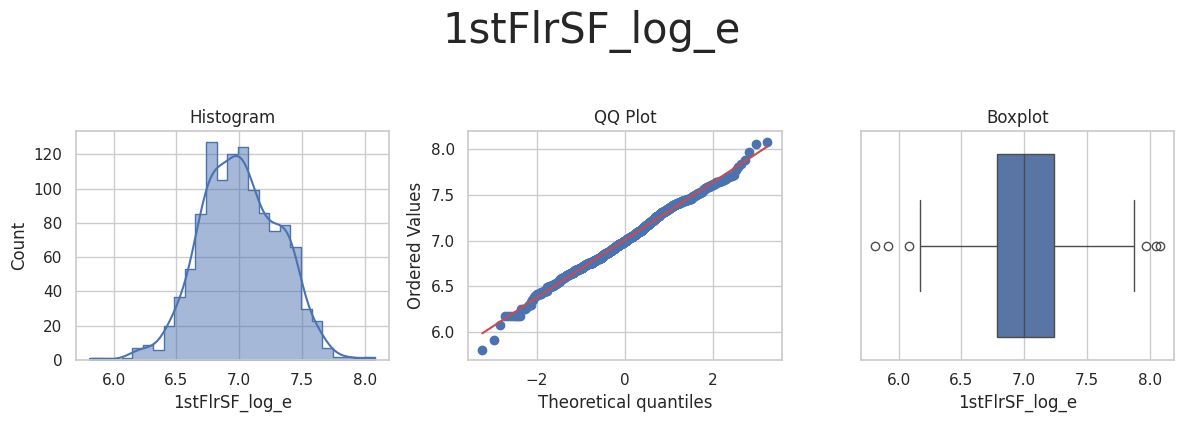

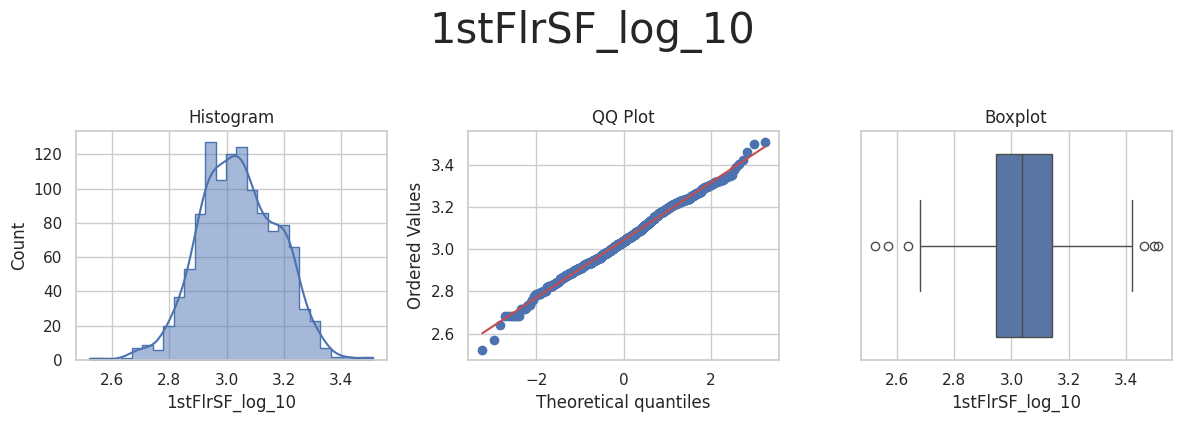

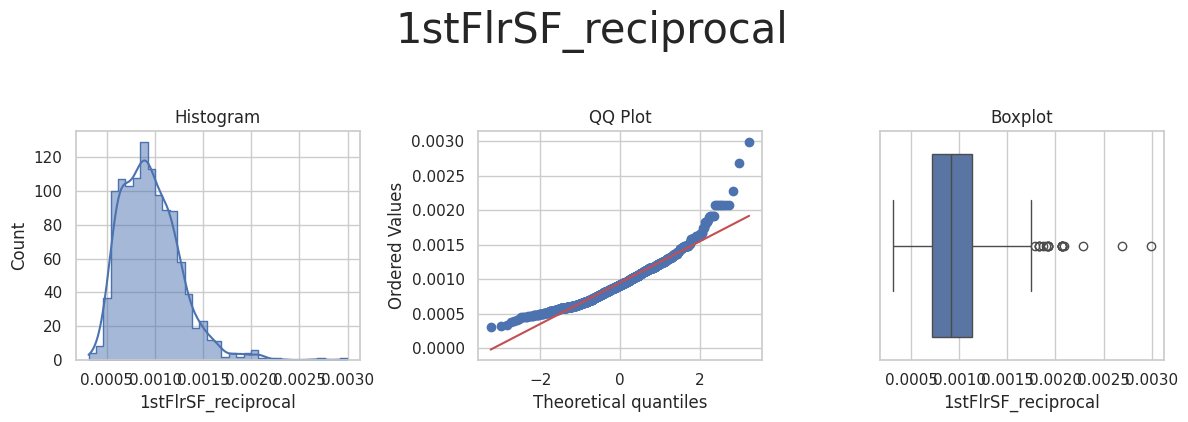

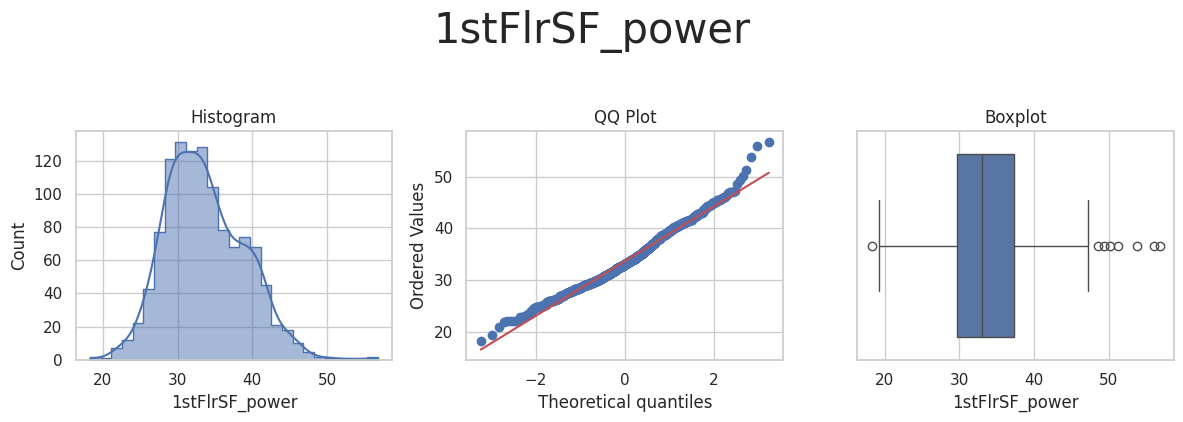

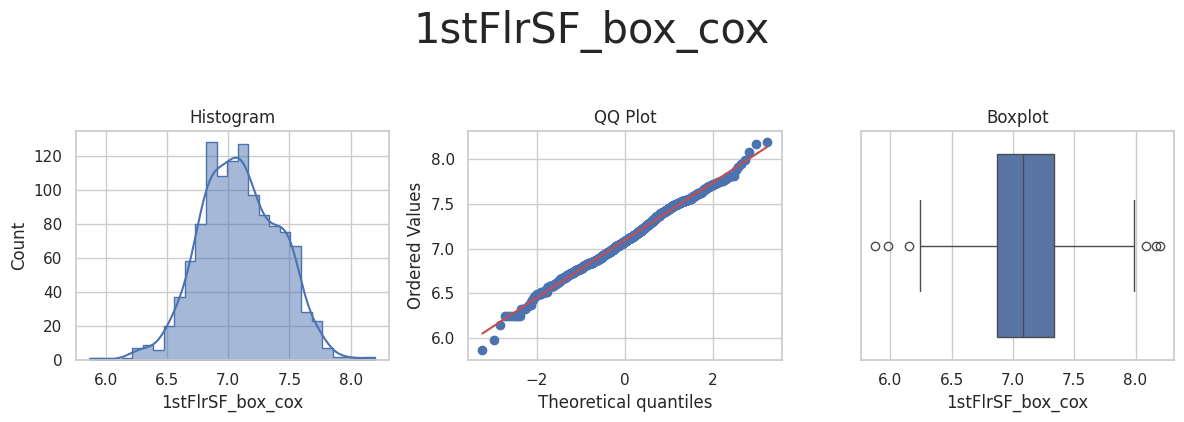

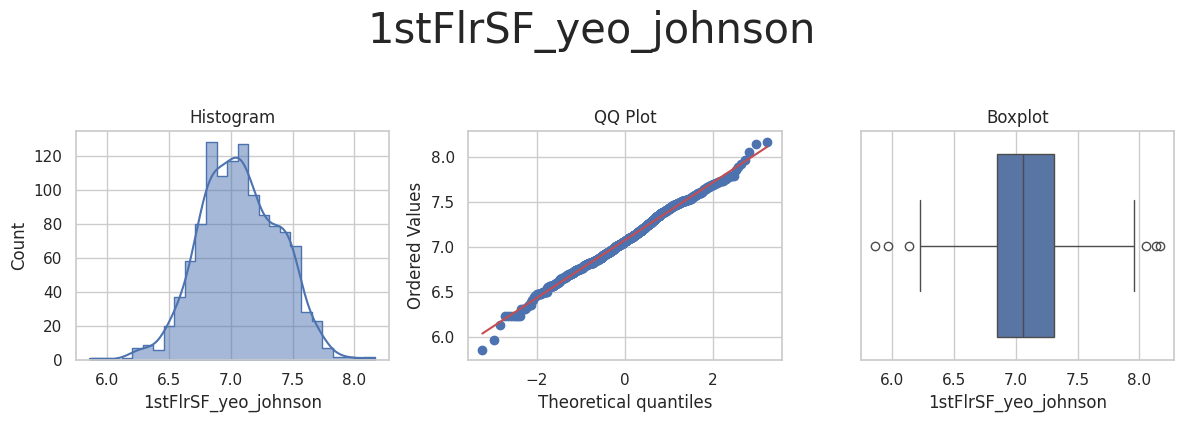



* Variable Analyzed: 2ndFlrSF
* Applied transformation: ['2ndFlrSF_power', '2ndFlrSF_yeo_johnson'] 



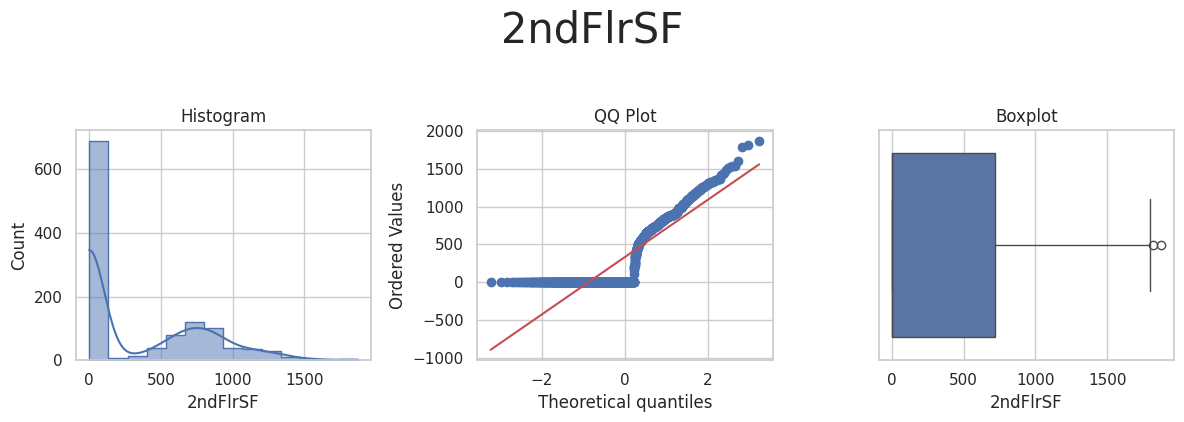

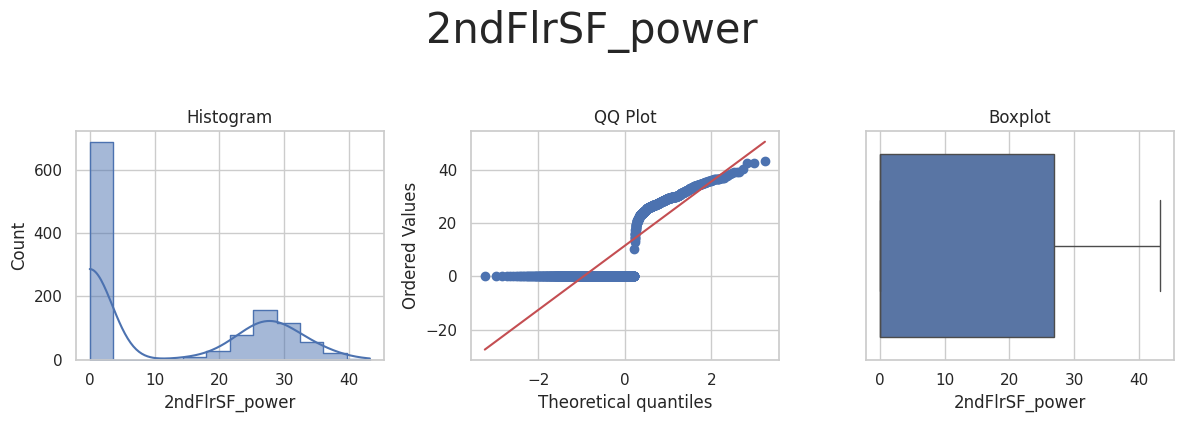

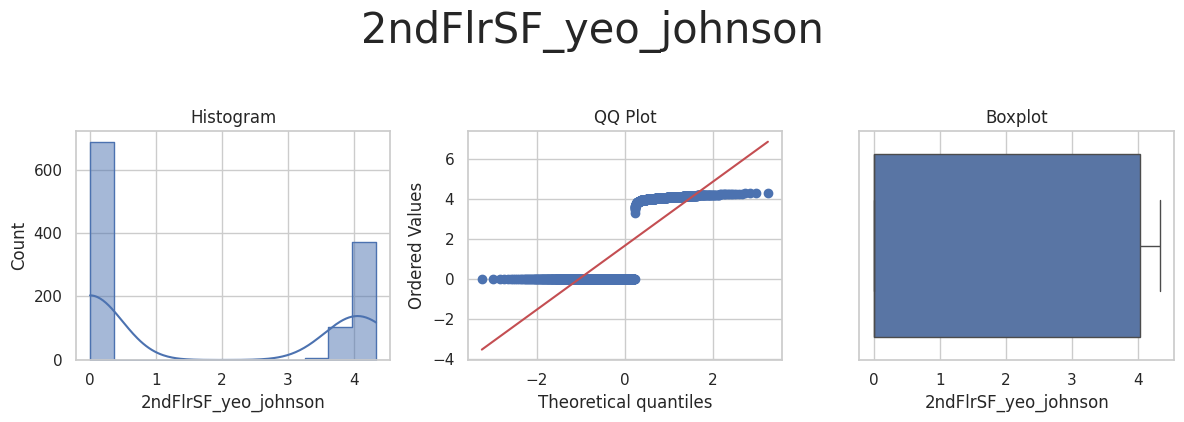



* Variable Analyzed: BedroomAbvGr
* Applied transformation: ['BedroomAbvGr_power', 'BedroomAbvGr_yeo_johnson'] 



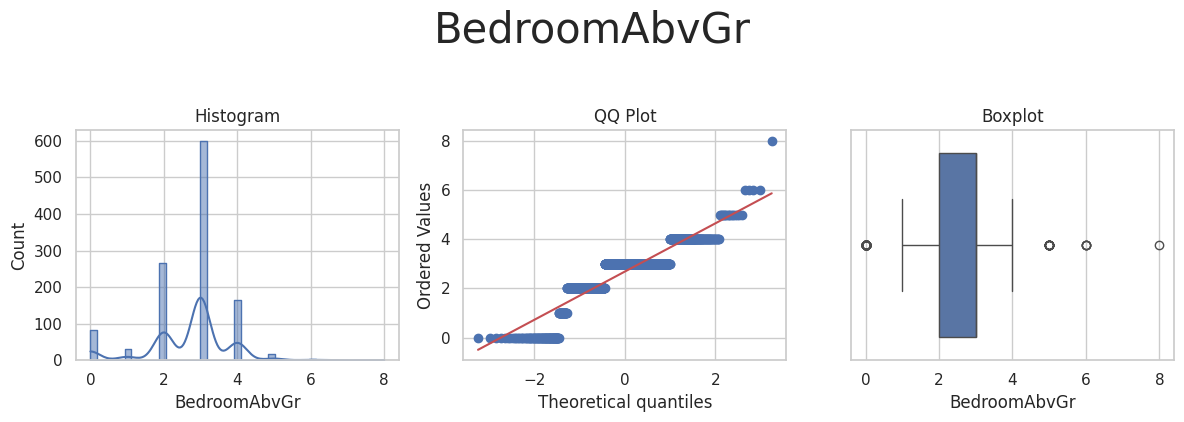

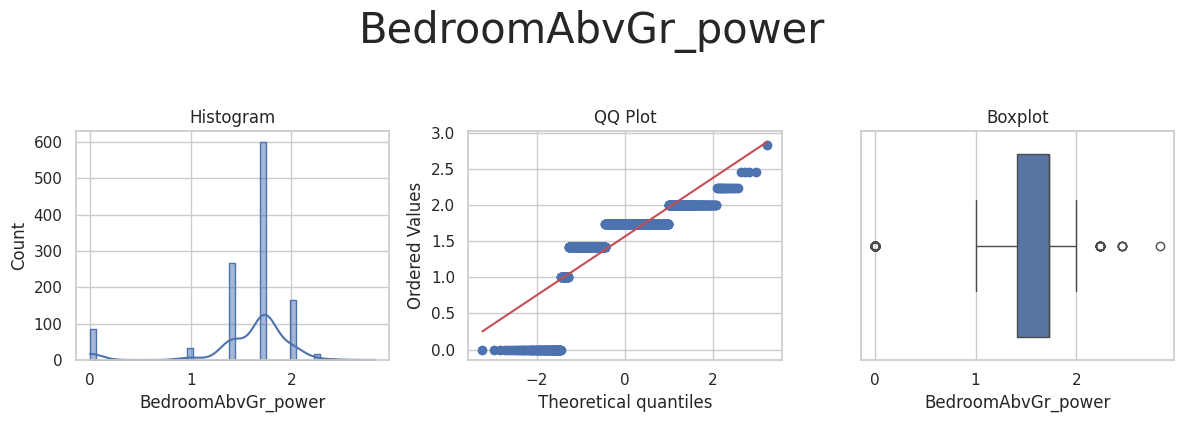

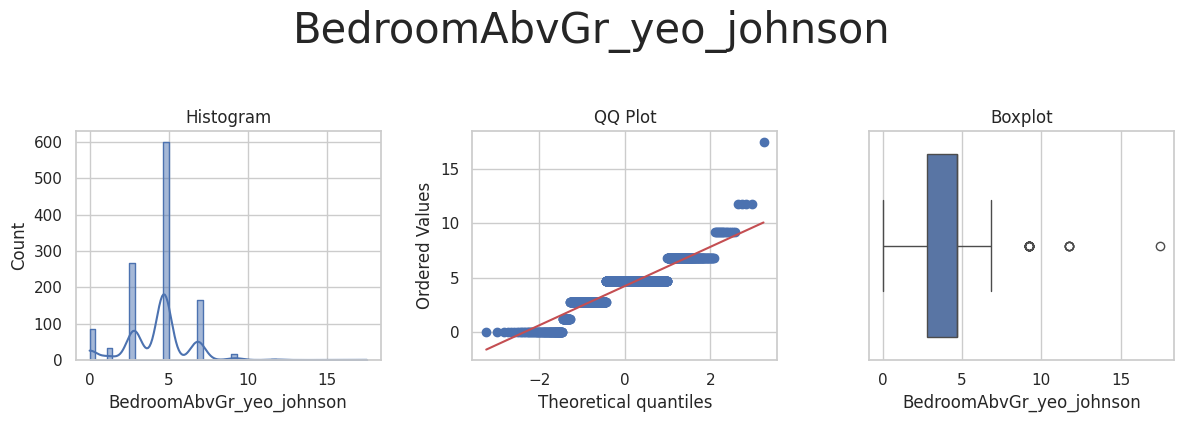



* Variable Analyzed: BsmtExposure
* Applied transformation: ['BsmtExposure_power', 'BsmtExposure_yeo_johnson'] 



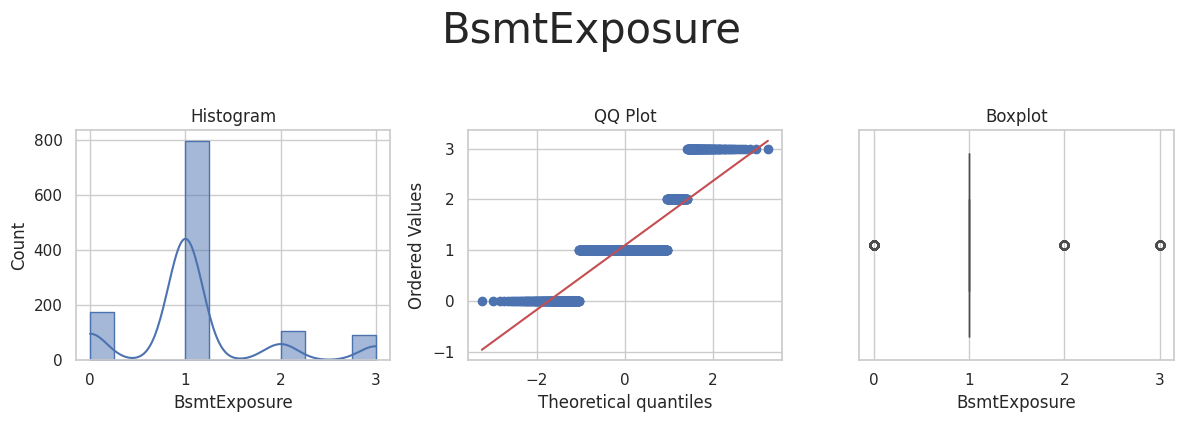

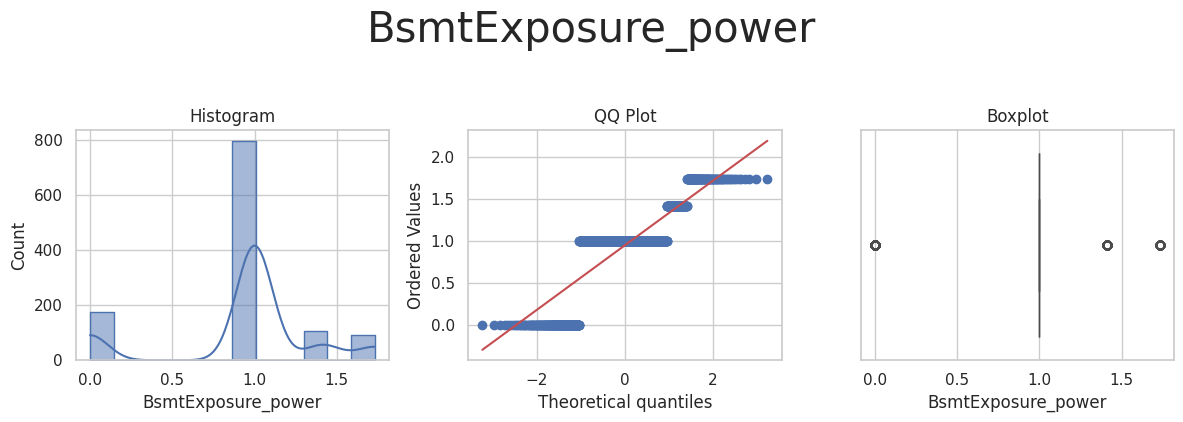

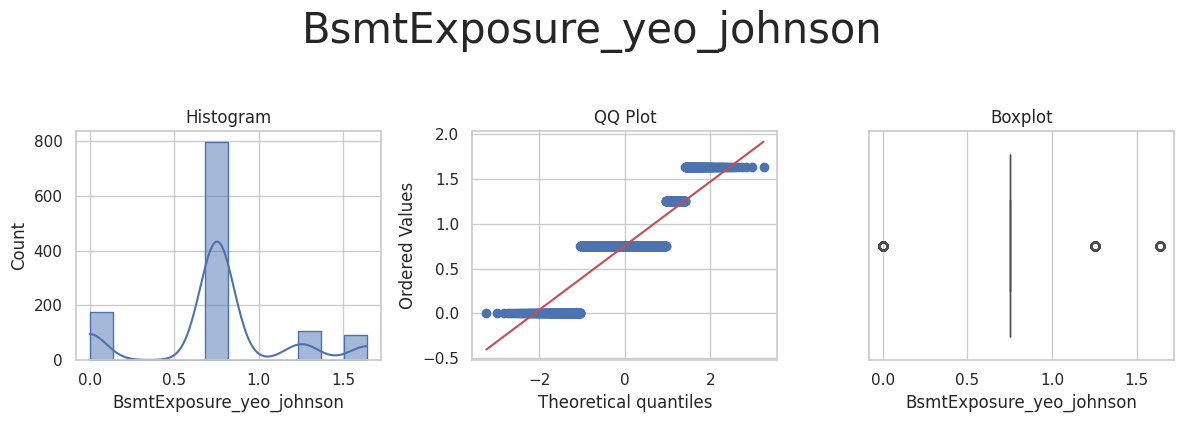



* Variable Analyzed: BsmtFinSF1
* Applied transformation: ['BsmtFinSF1_power', 'BsmtFinSF1_yeo_johnson'] 



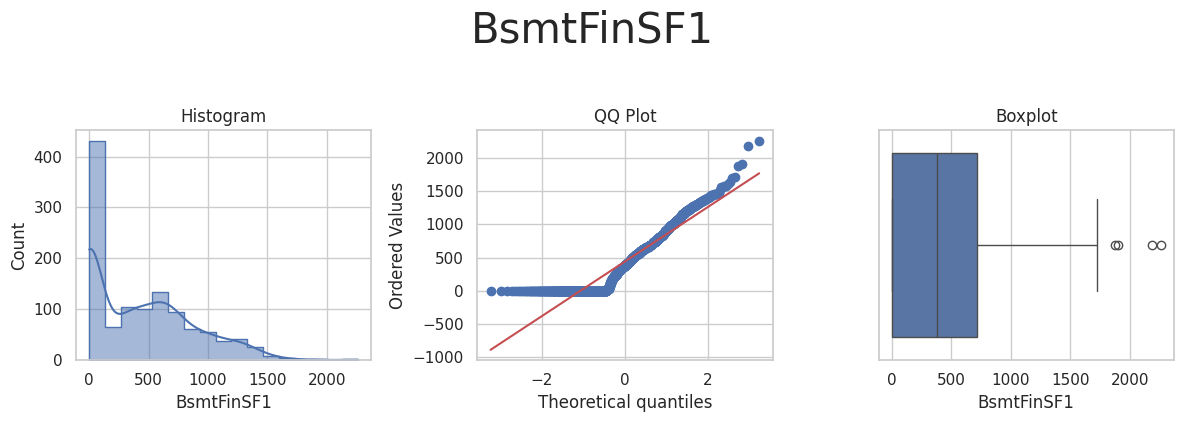

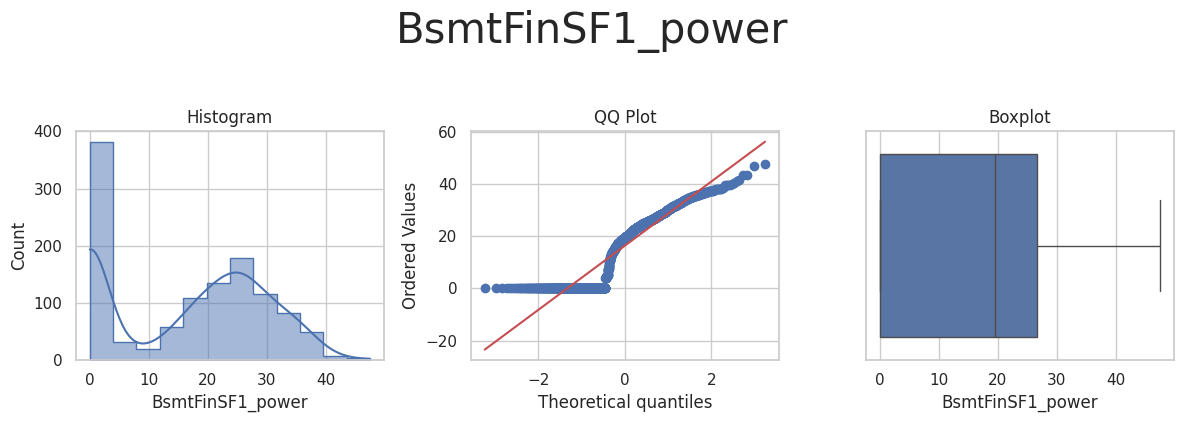

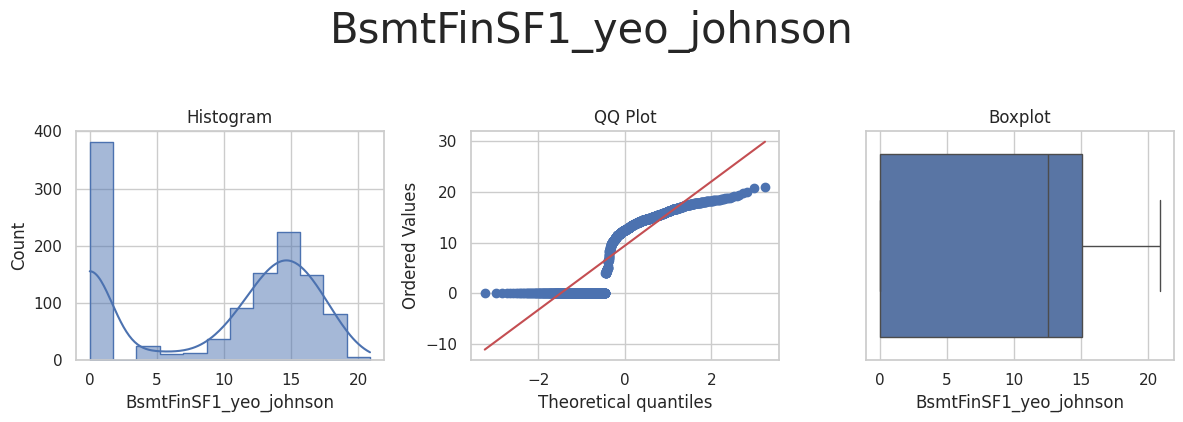



* Variable Analyzed: BsmtFinType1
* Applied transformation: ['BsmtFinType1_power', 'BsmtFinType1_yeo_johnson'] 



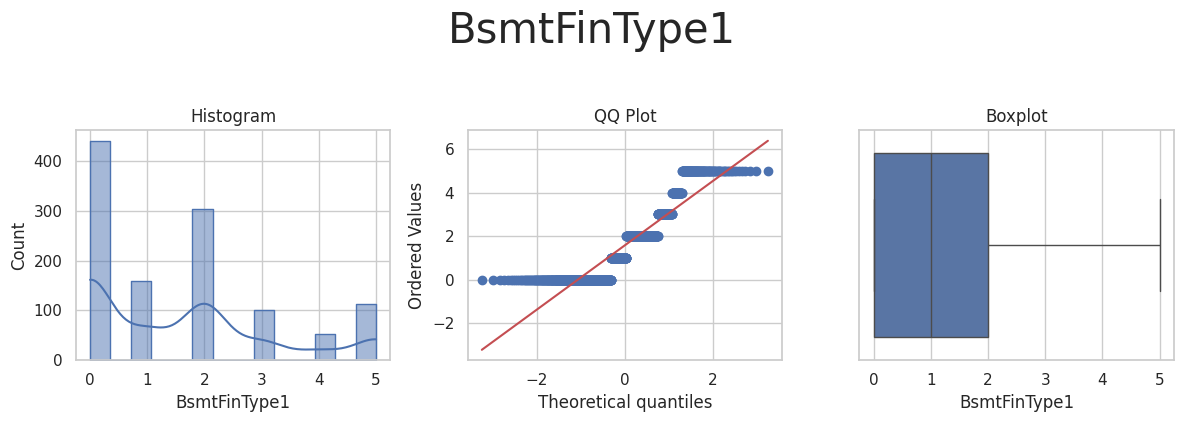

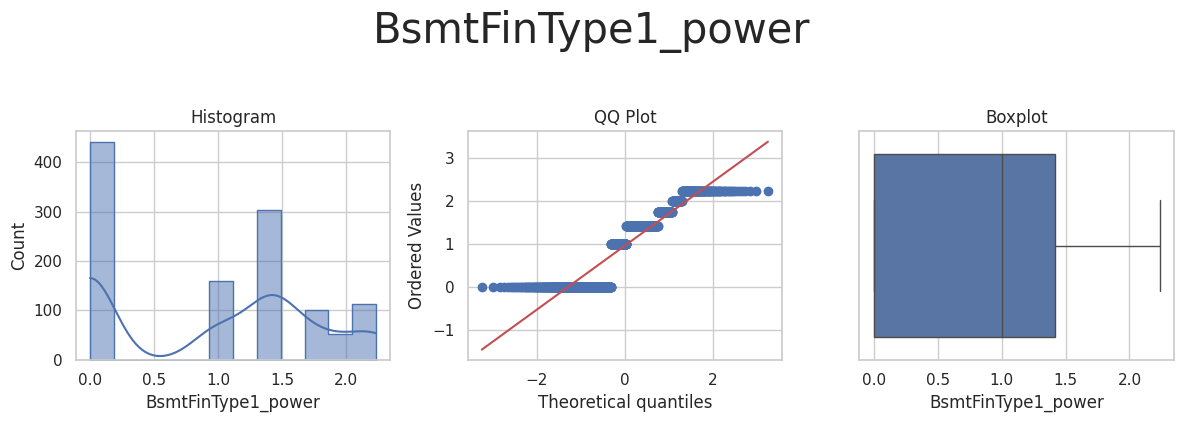

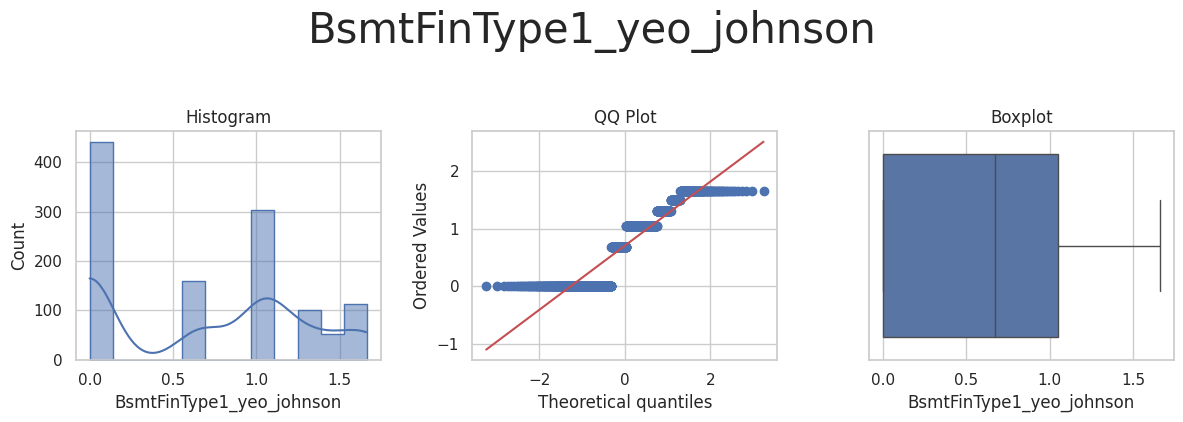



* Variable Analyzed: BsmtUnfSF
* Applied transformation: ['BsmtUnfSF_power', 'BsmtUnfSF_yeo_johnson'] 



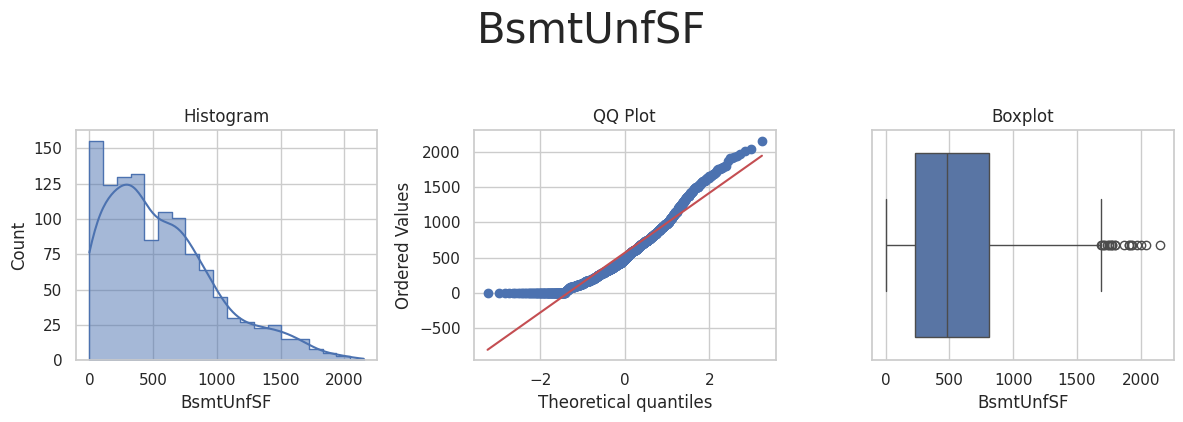

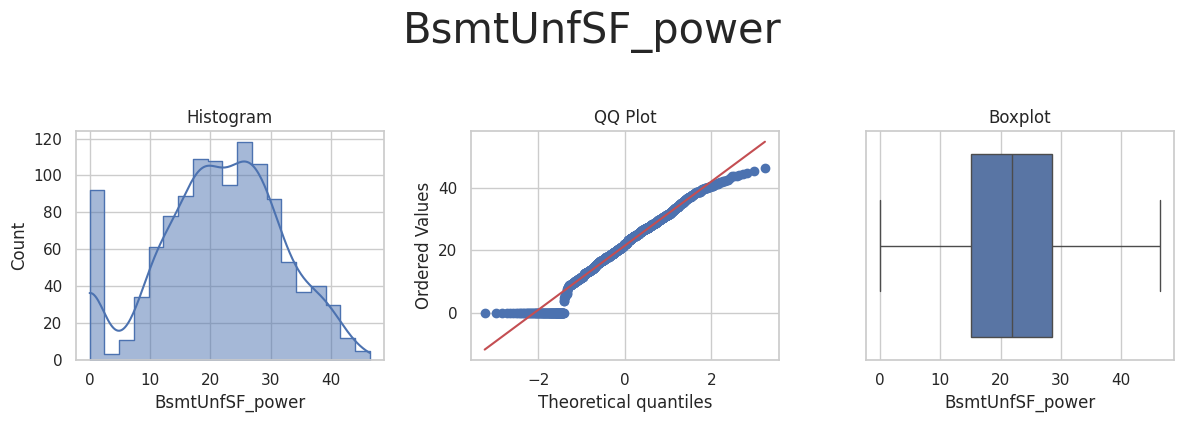

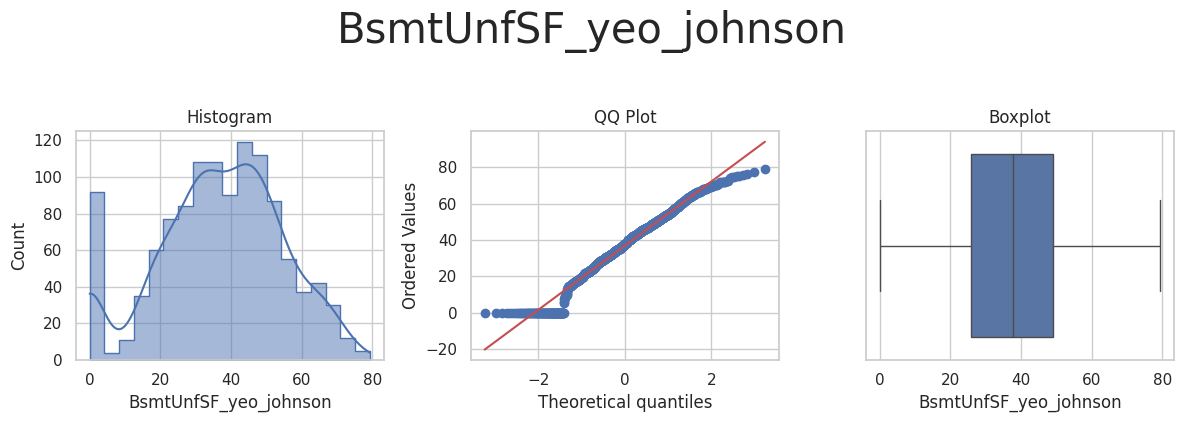



* Variable Analyzed: GarageArea
* Applied transformation: ['GarageArea_power', 'GarageArea_yeo_johnson'] 



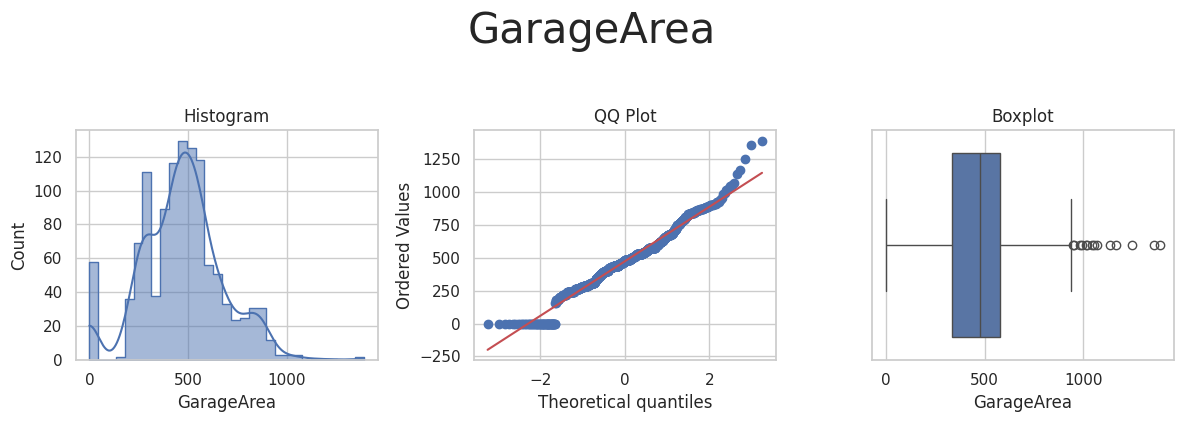

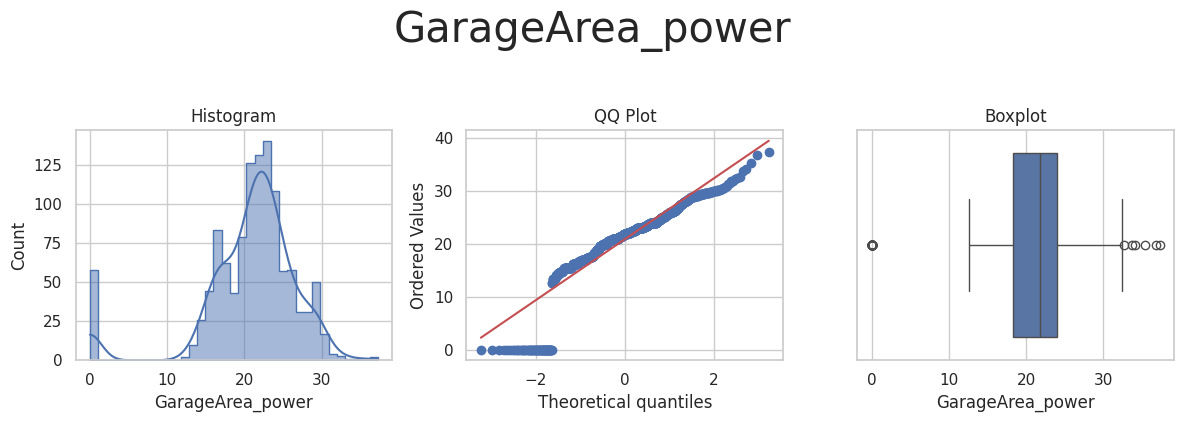

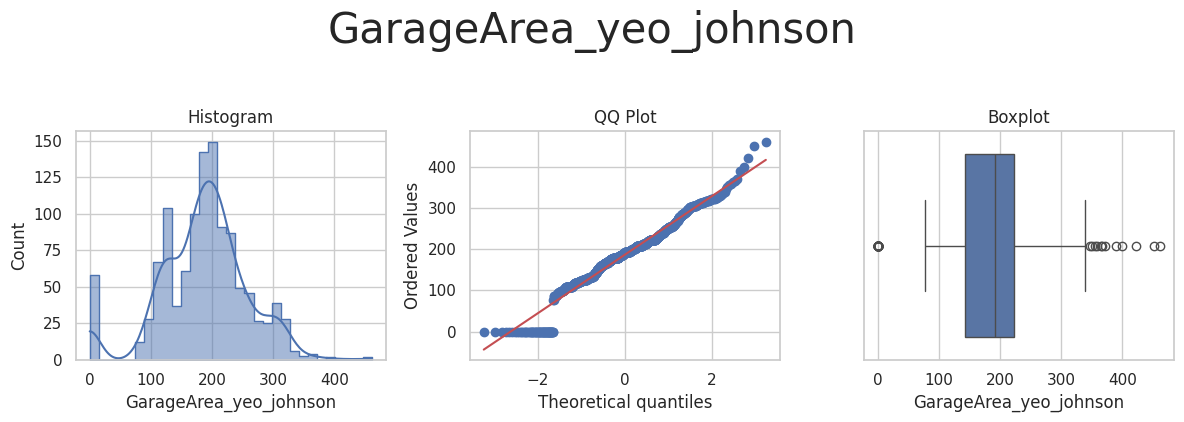



* Variable Analyzed: GarageFinish
* Applied transformation: ['GarageFinish_power', 'GarageFinish_yeo_johnson'] 



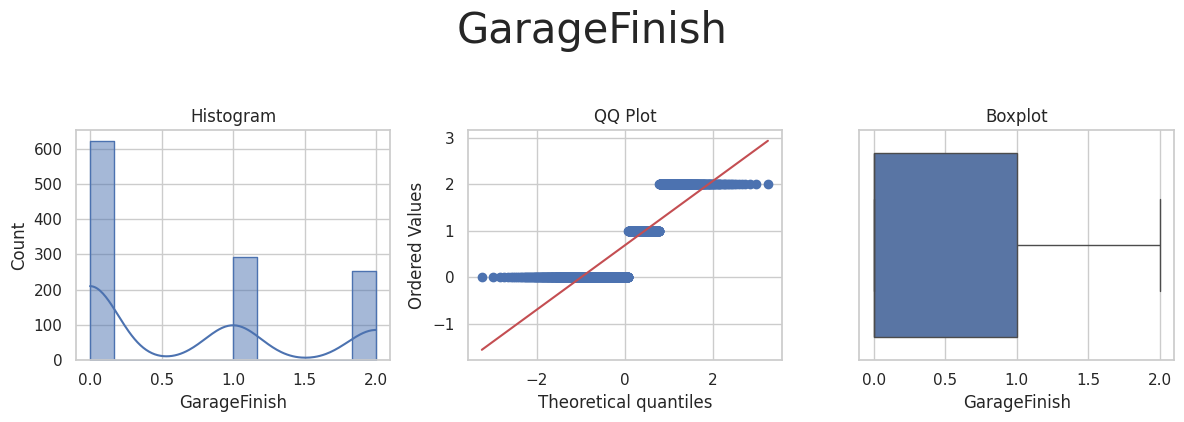

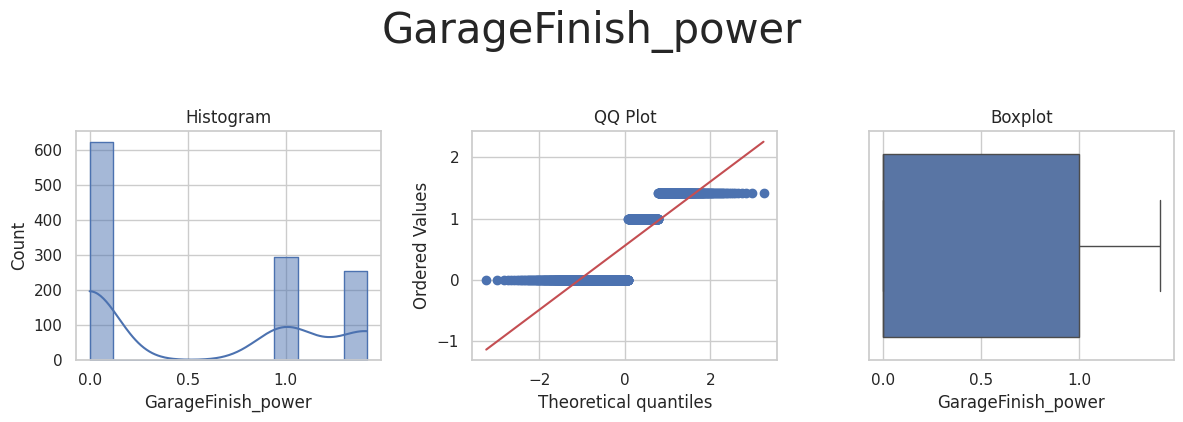

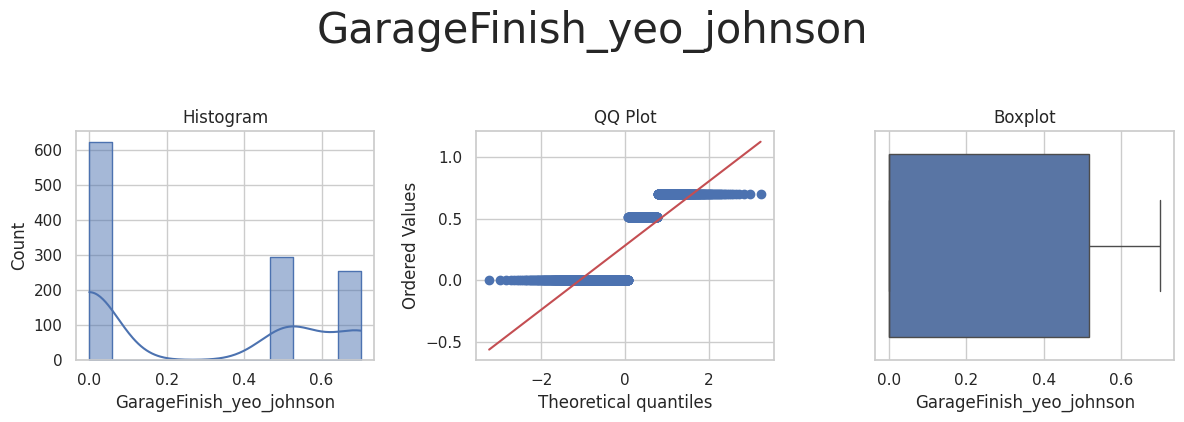



* Variable Analyzed: GarageYrBlt
* Applied transformation: ['GarageYrBlt_log_e', 'GarageYrBlt_log_10', 'GarageYrBlt_reciprocal', 'GarageYrBlt_power', 'GarageYrBlt_box_cox', 'GarageYrBlt_yeo_johnson'] 



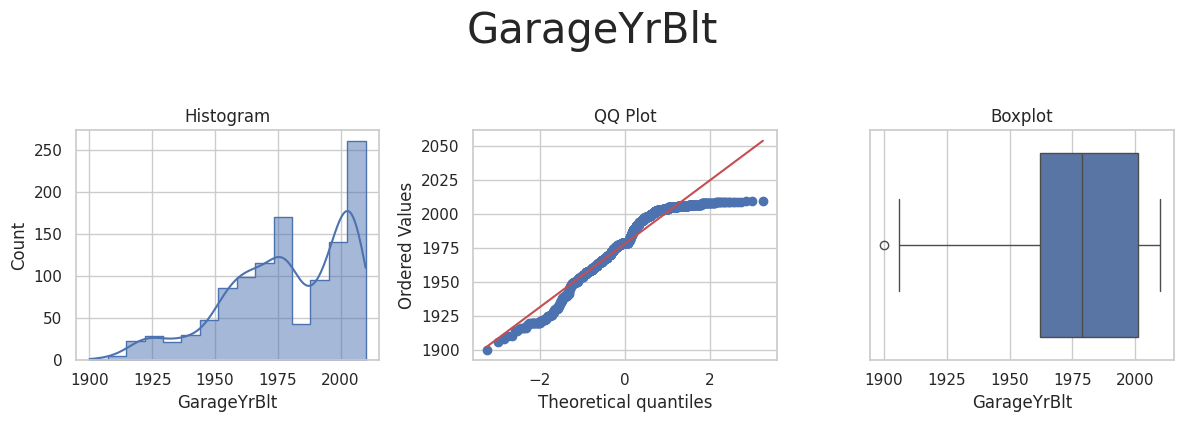

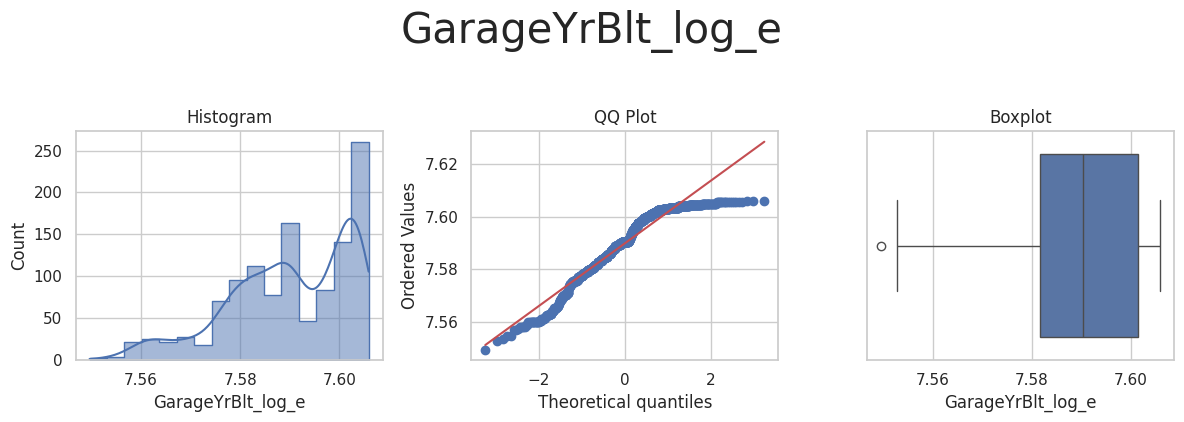

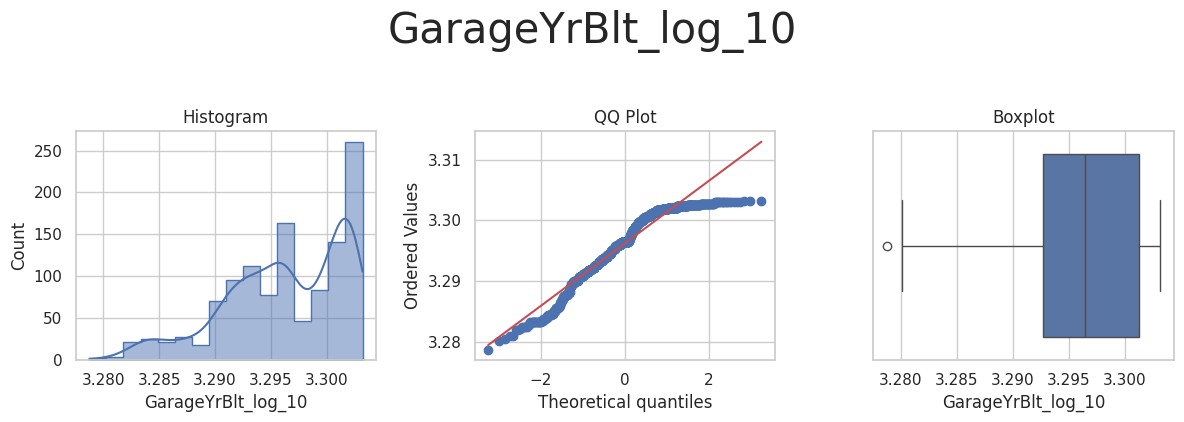

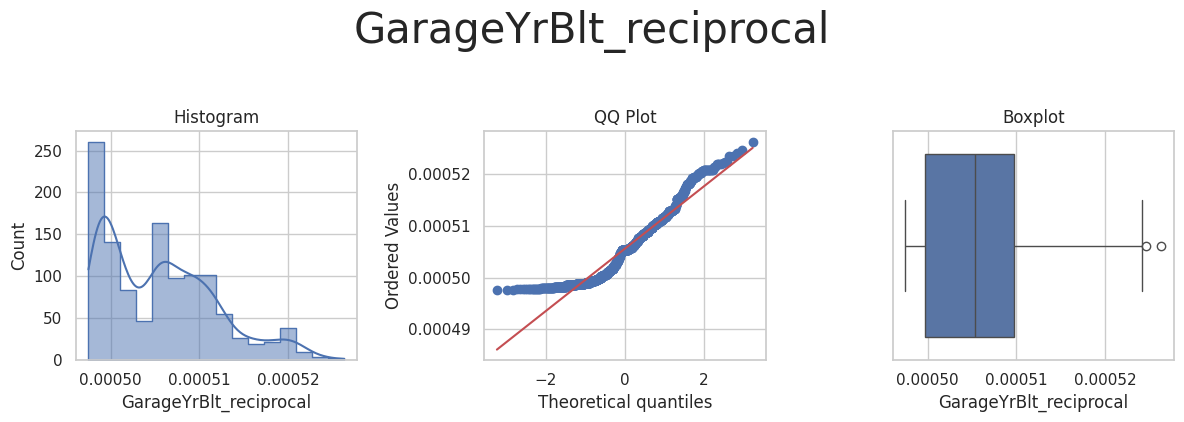

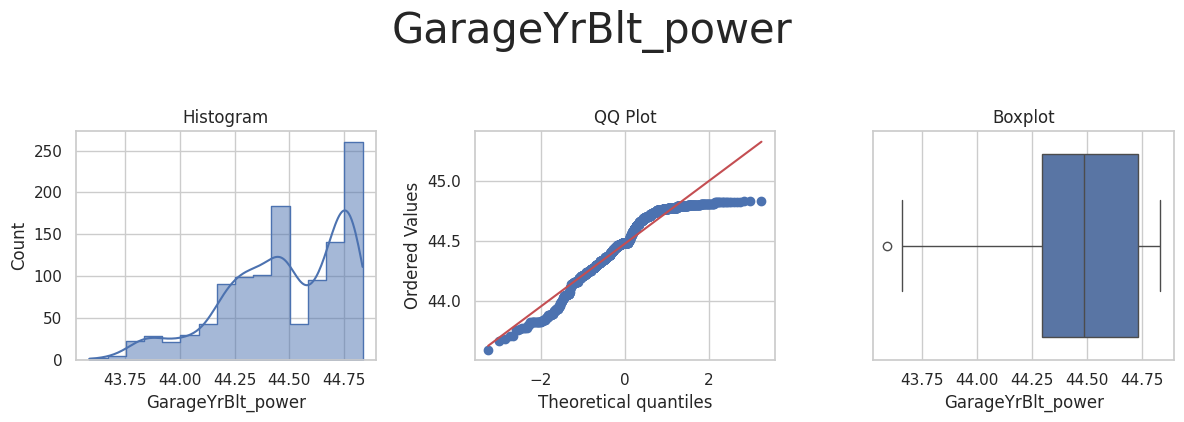

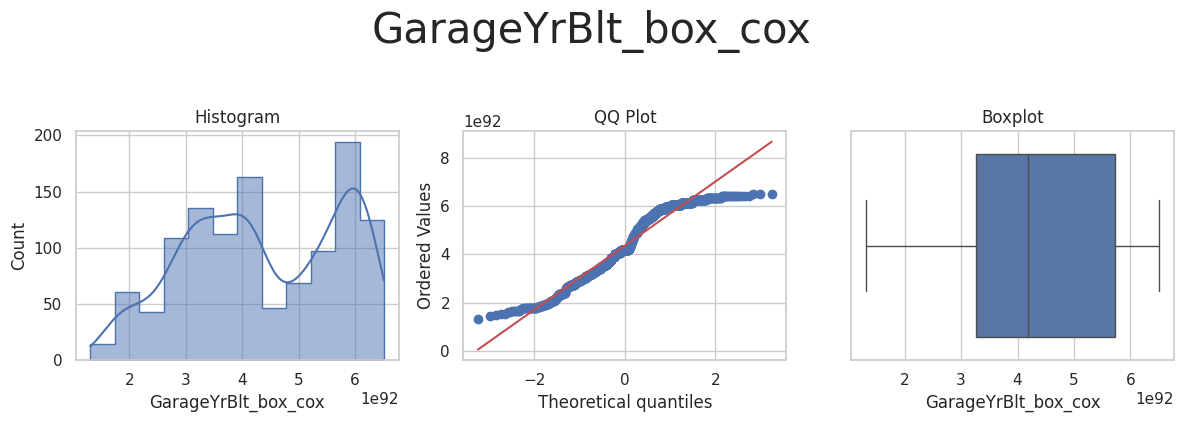

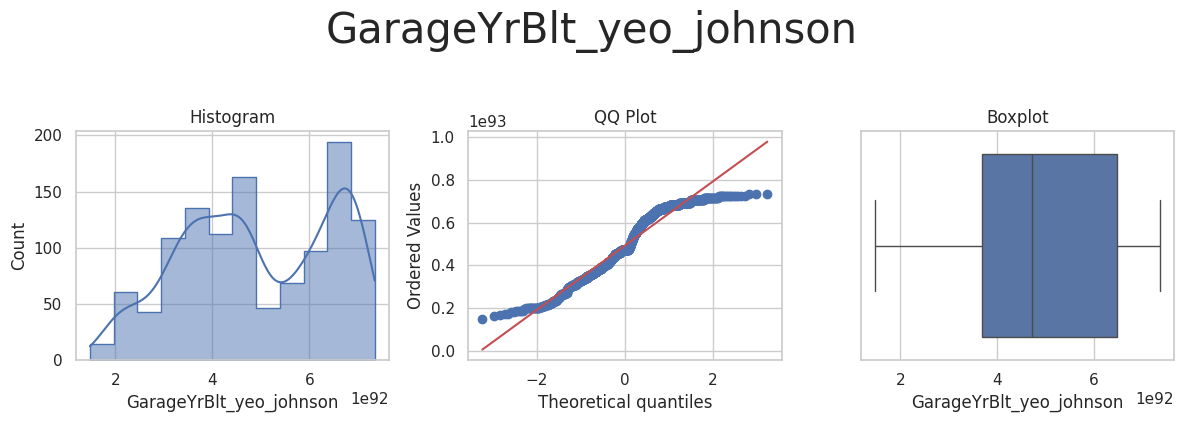



* Variable Analyzed: GrLivArea
* Applied transformation: ['GrLivArea_log_e', 'GrLivArea_log_10', 'GrLivArea_reciprocal', 'GrLivArea_power', 'GrLivArea_box_cox', 'GrLivArea_yeo_johnson'] 



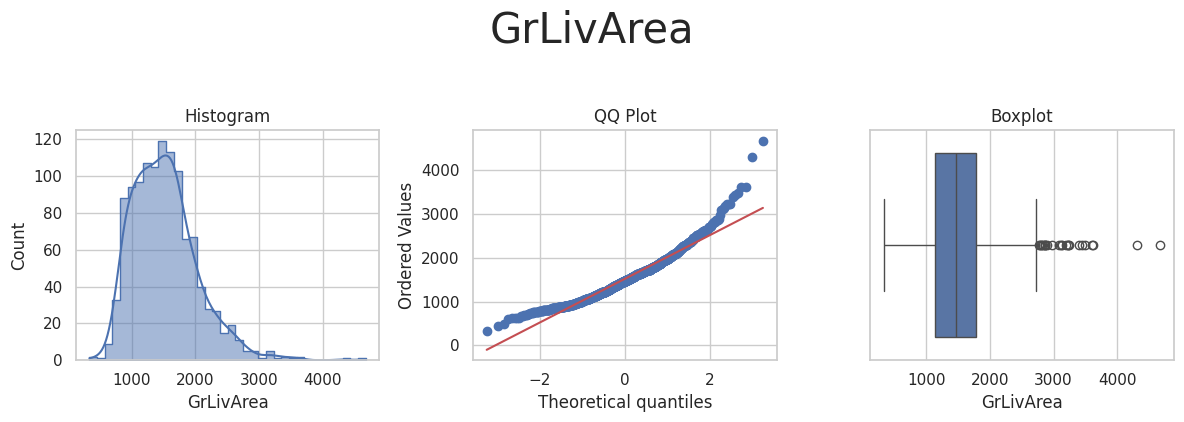

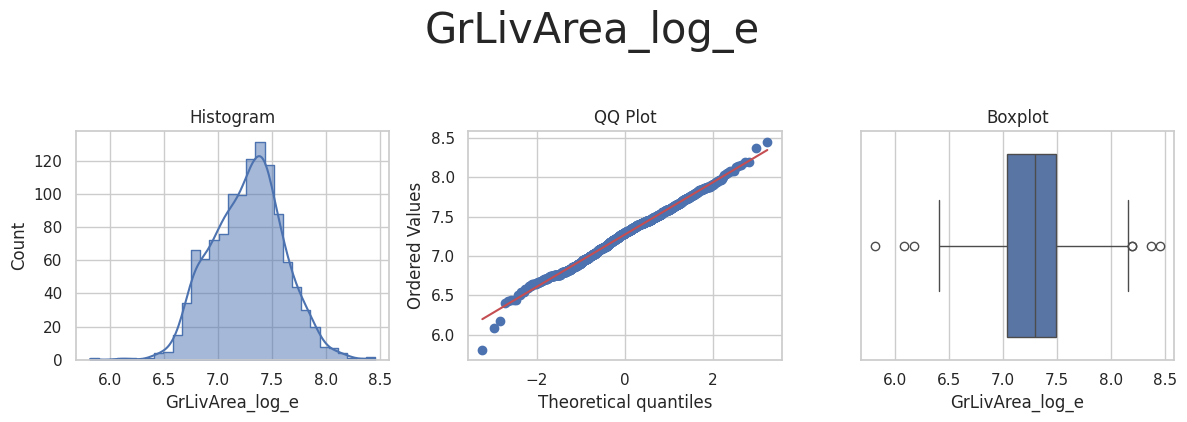

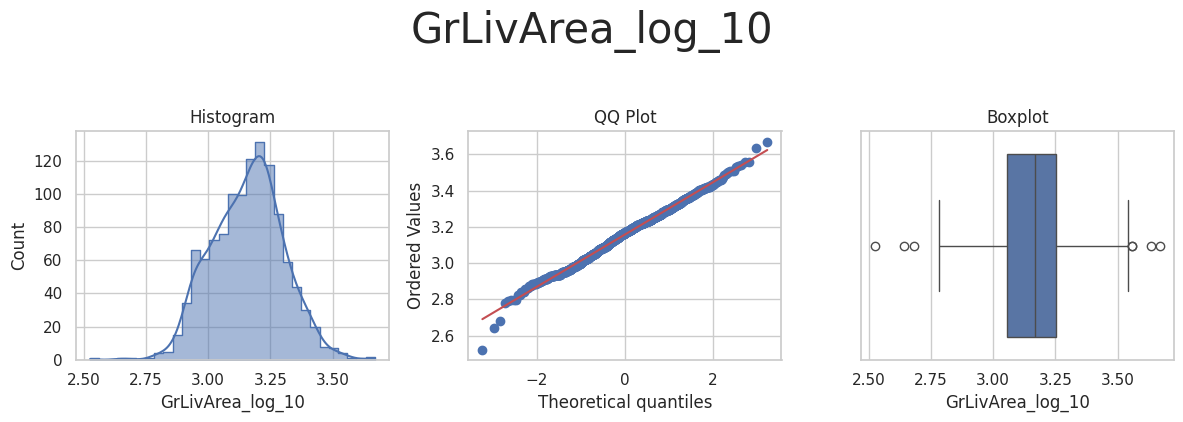

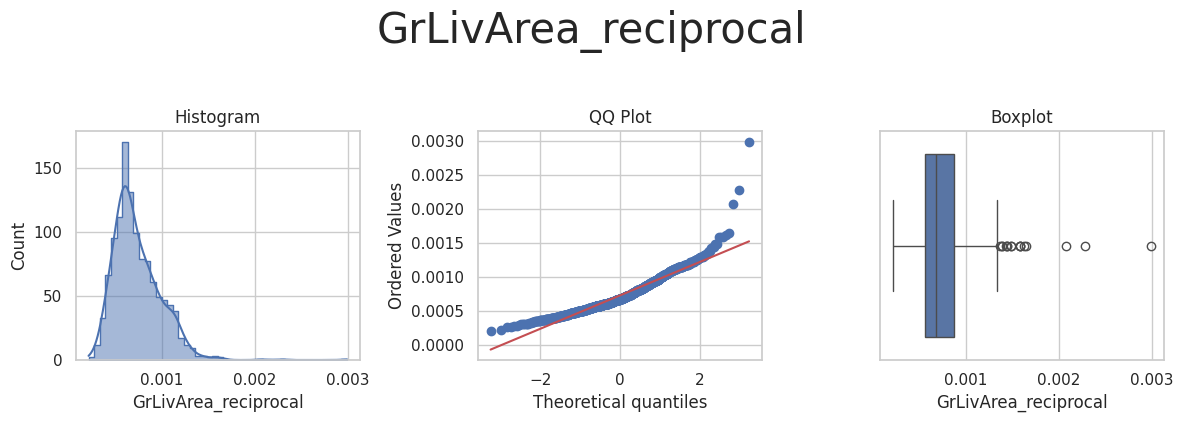

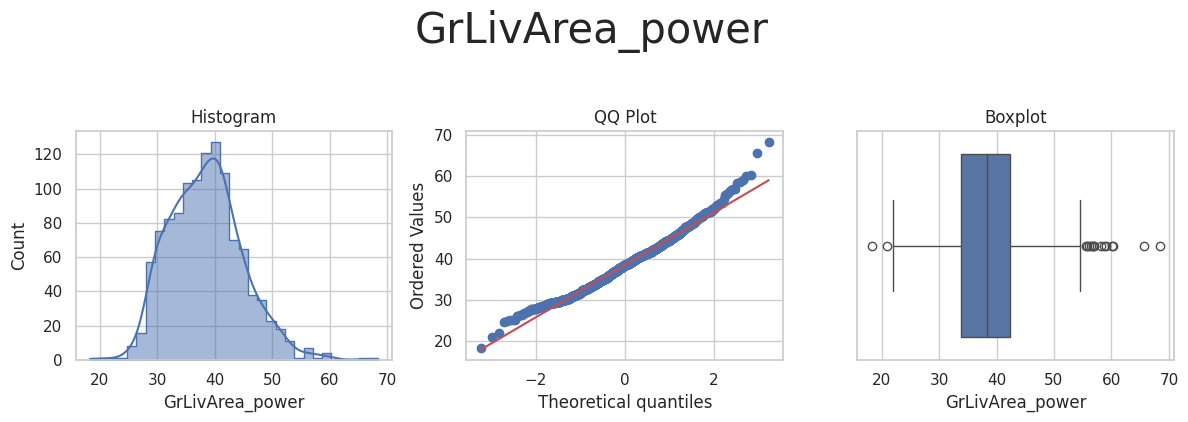

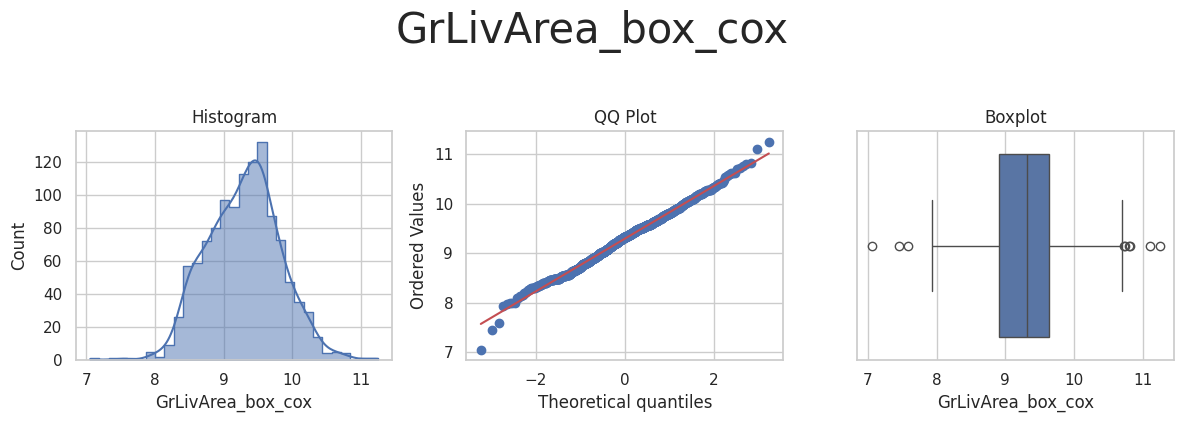

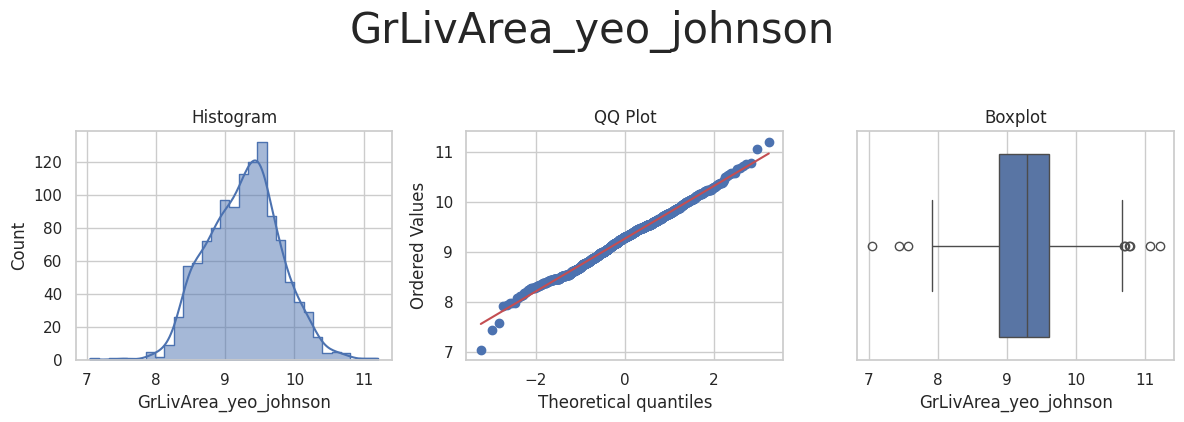



* Variable Analyzed: KitchenQual
* Applied transformation: ['KitchenQual_power', 'KitchenQual_yeo_johnson'] 



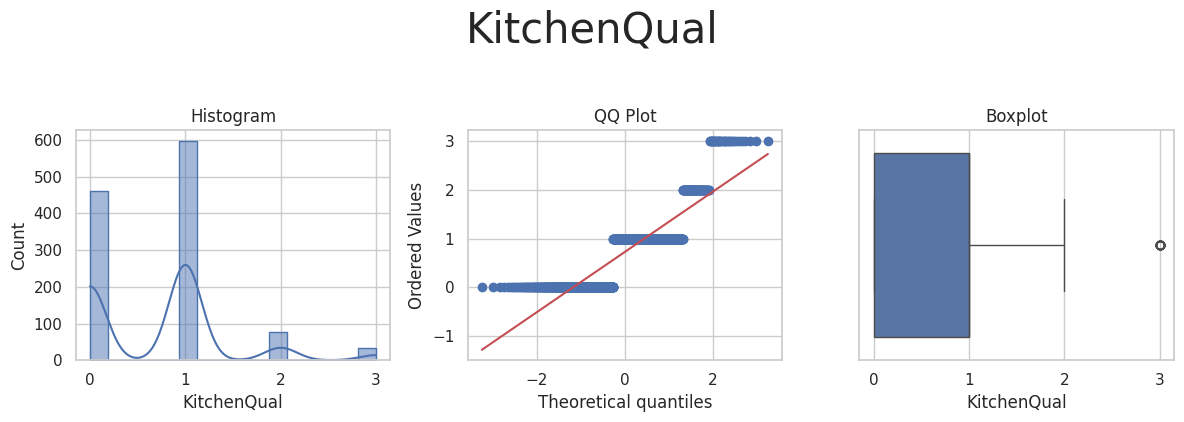

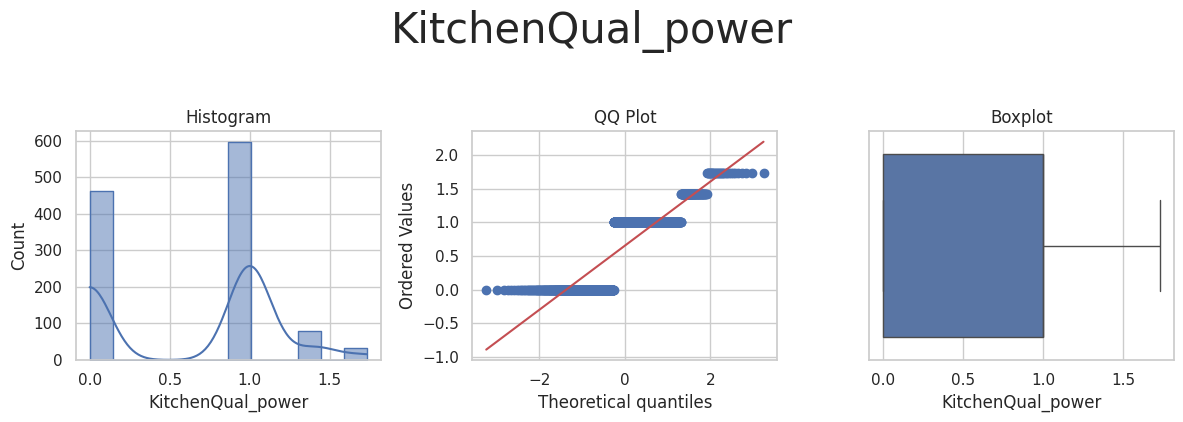

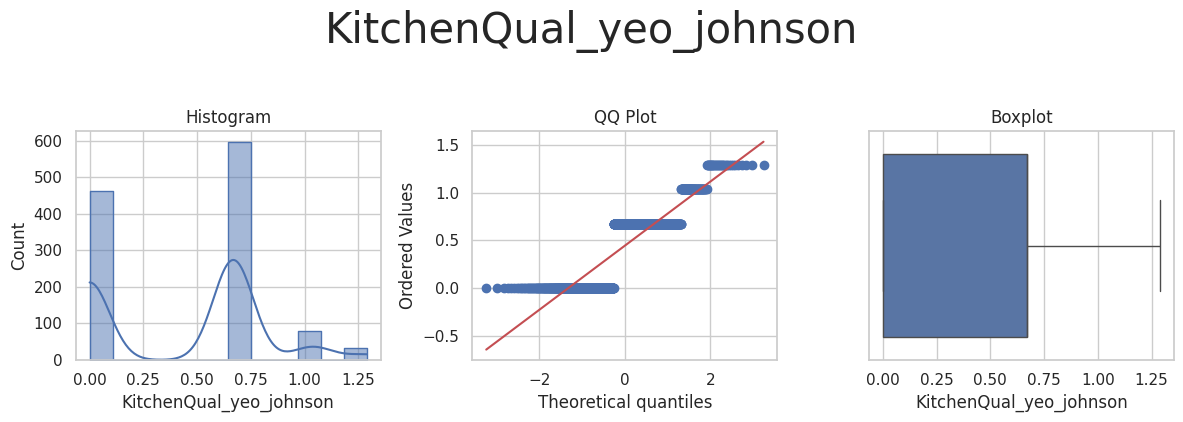



* Variable Analyzed: LotArea
* Applied transformation: ['LotArea_log_e', 'LotArea_log_10', 'LotArea_reciprocal', 'LotArea_power', 'LotArea_box_cox', 'LotArea_yeo_johnson'] 



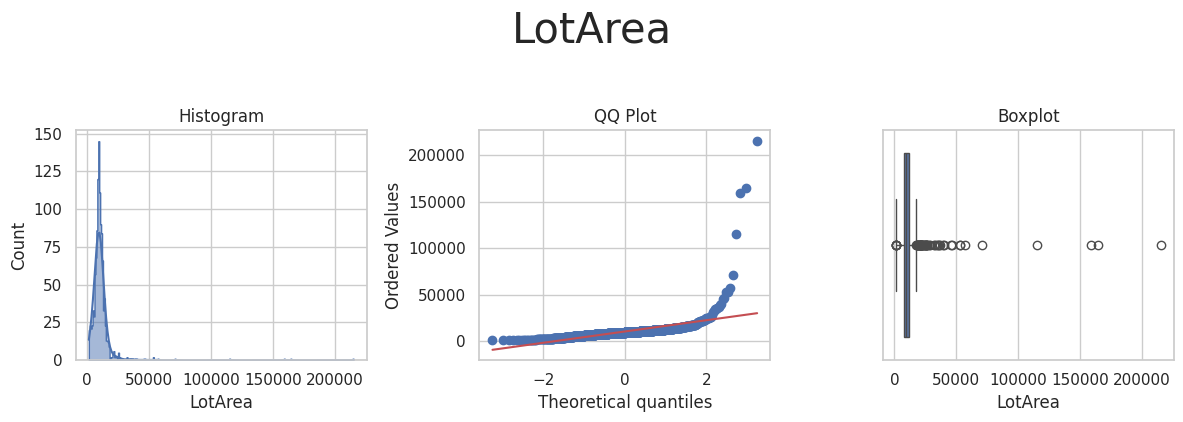

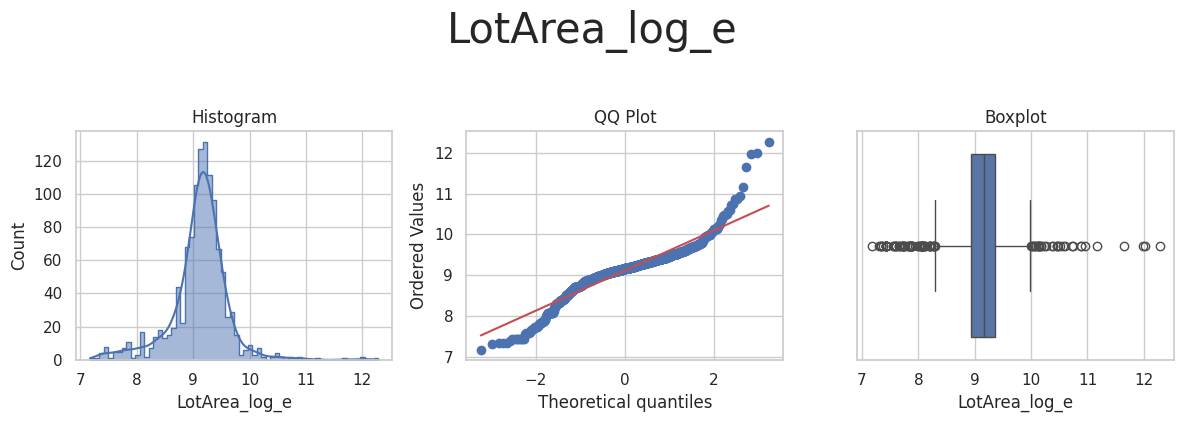

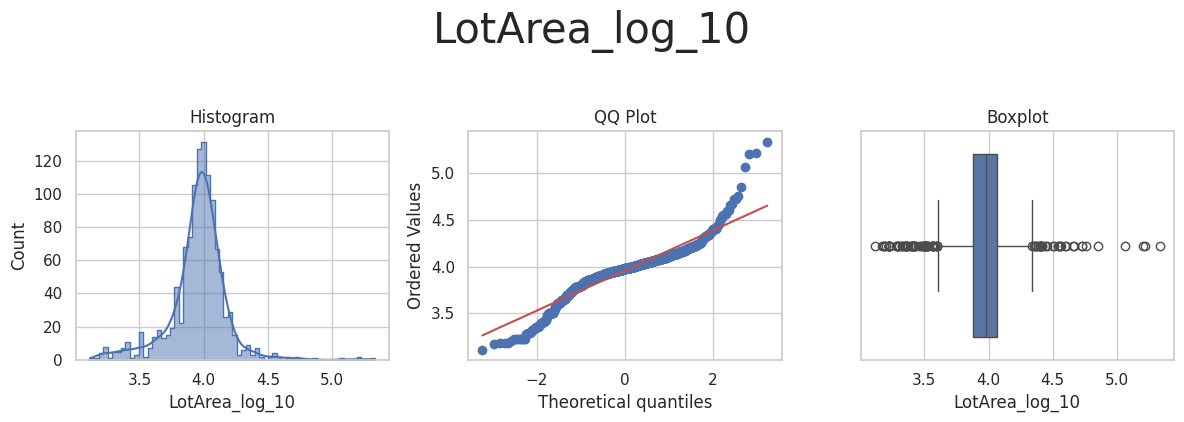

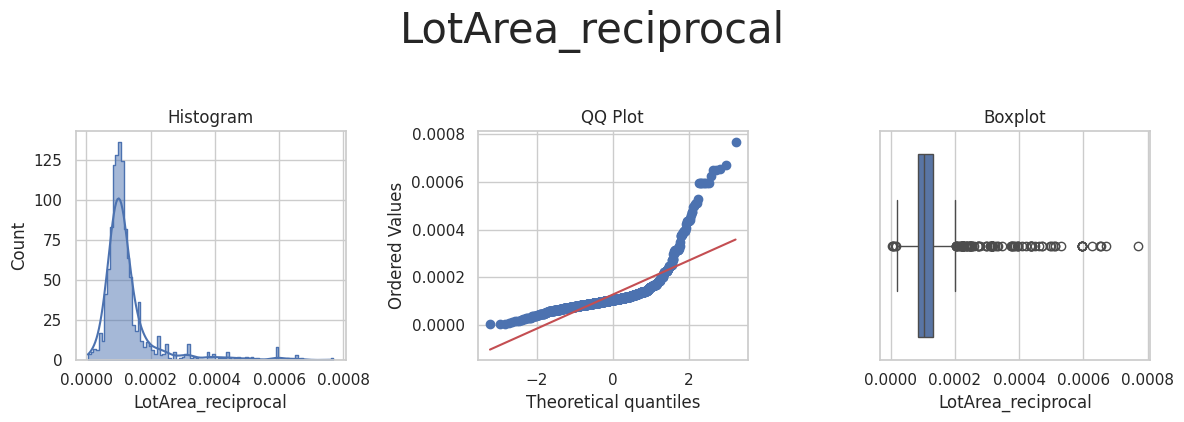

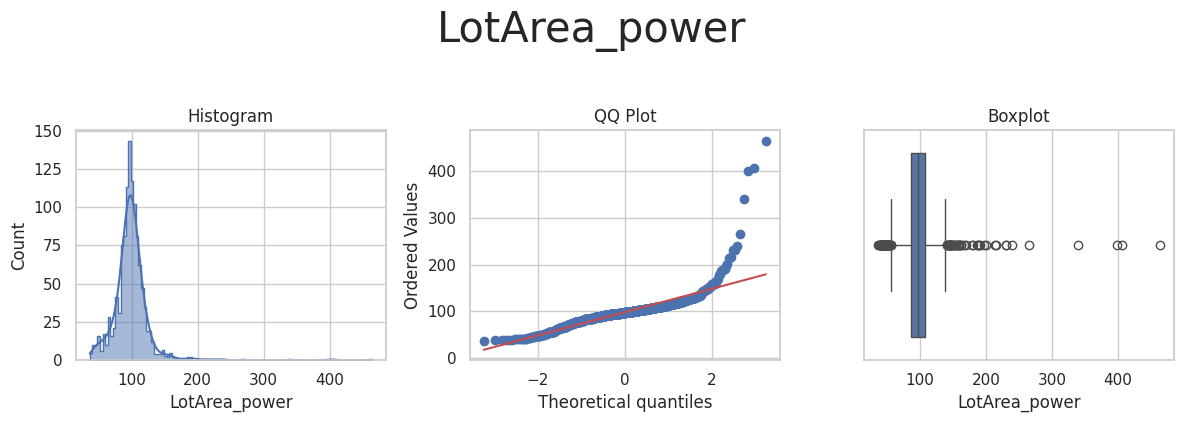

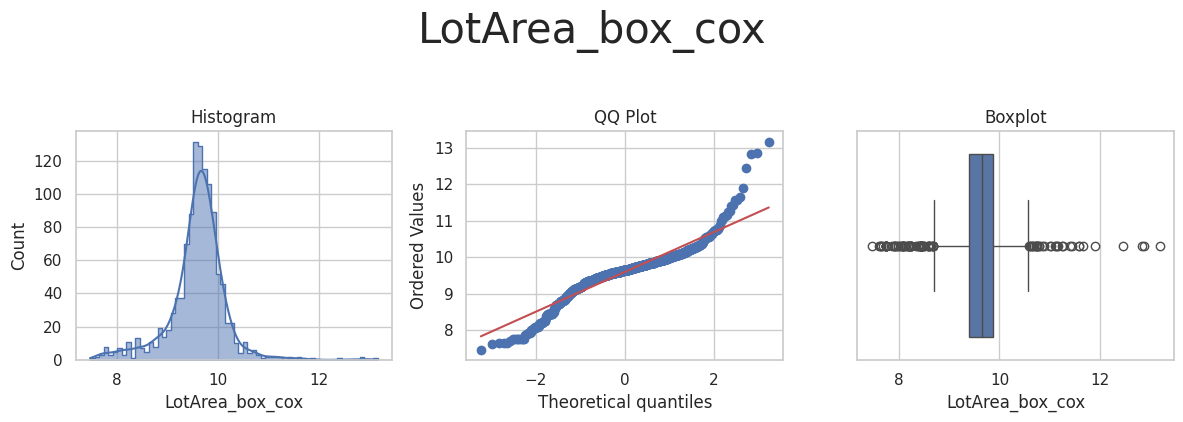

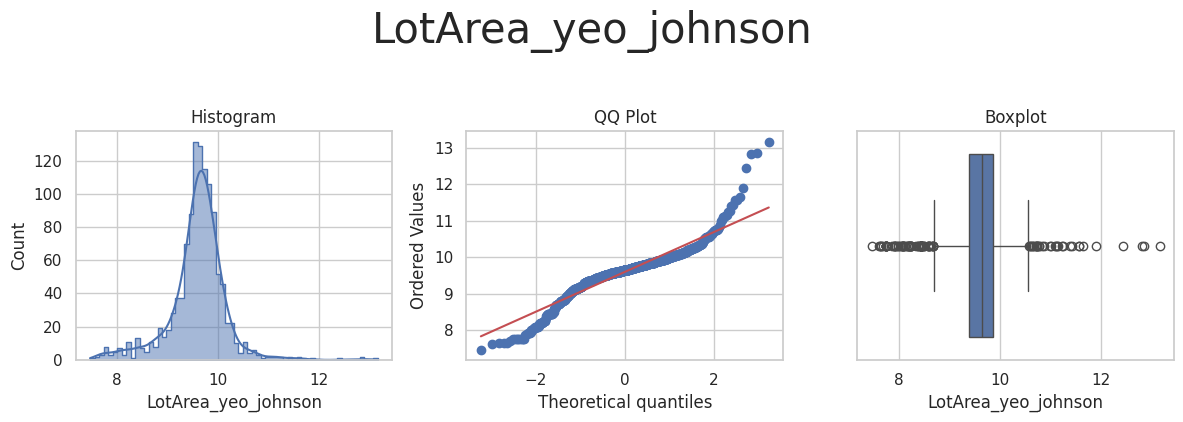



* Variable Analyzed: LotFrontage
* Applied transformation: ['LotFrontage_log_e', 'LotFrontage_log_10', 'LotFrontage_reciprocal', 'LotFrontage_power', 'LotFrontage_box_cox', 'LotFrontage_yeo_johnson'] 



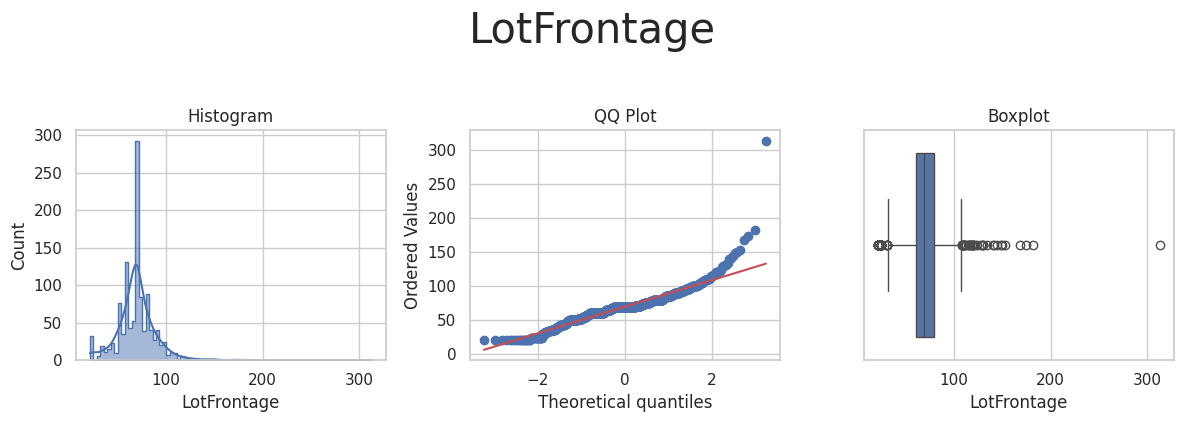

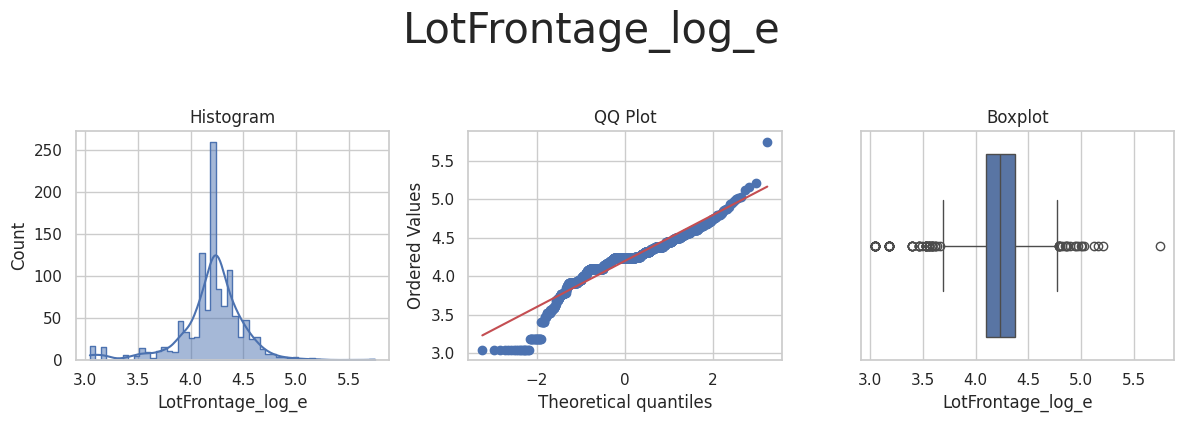

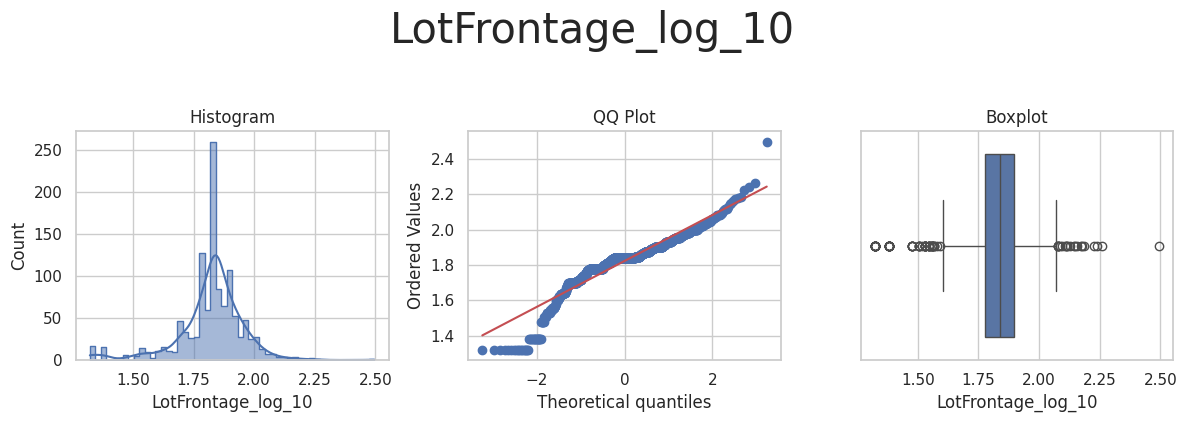

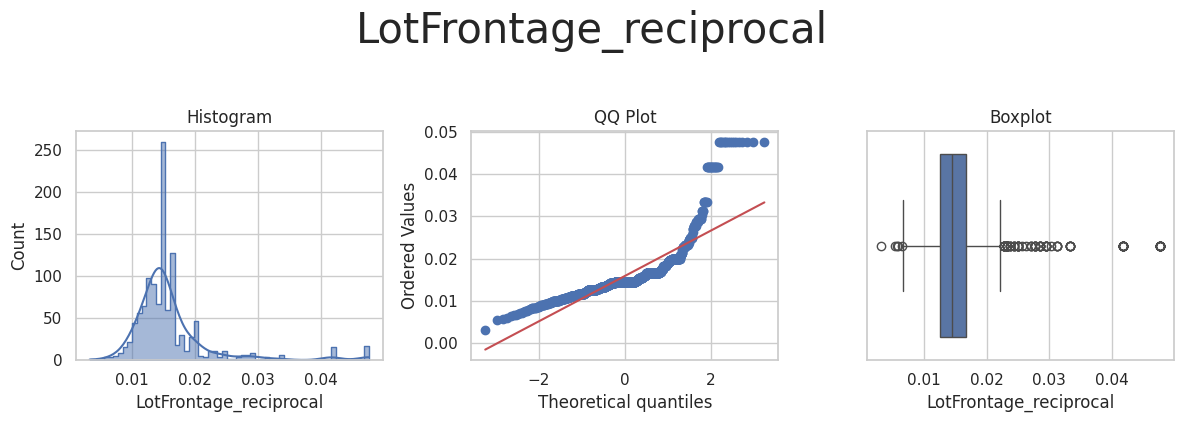

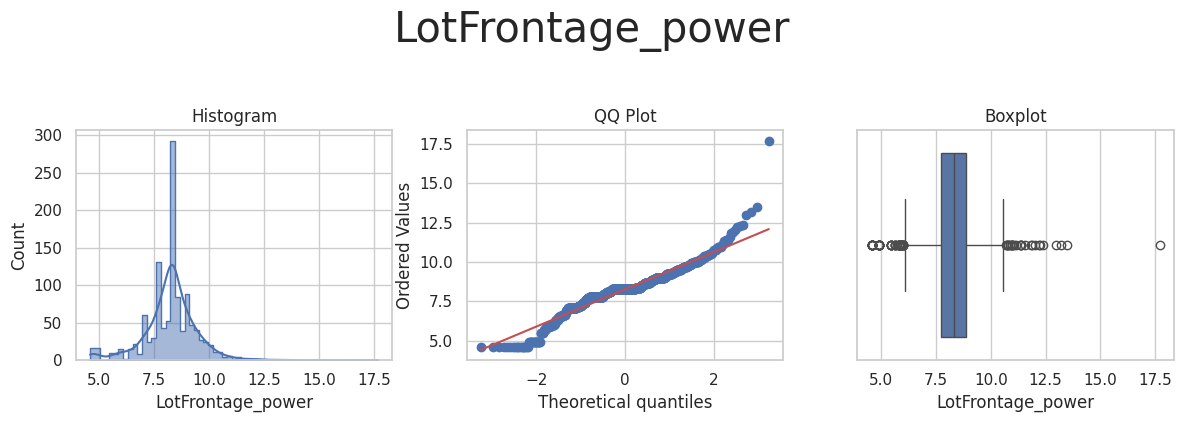

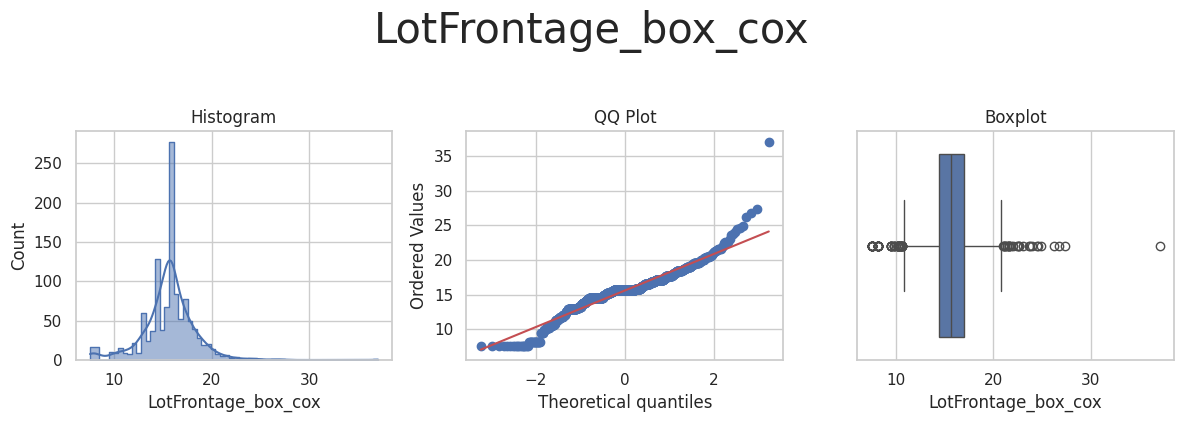

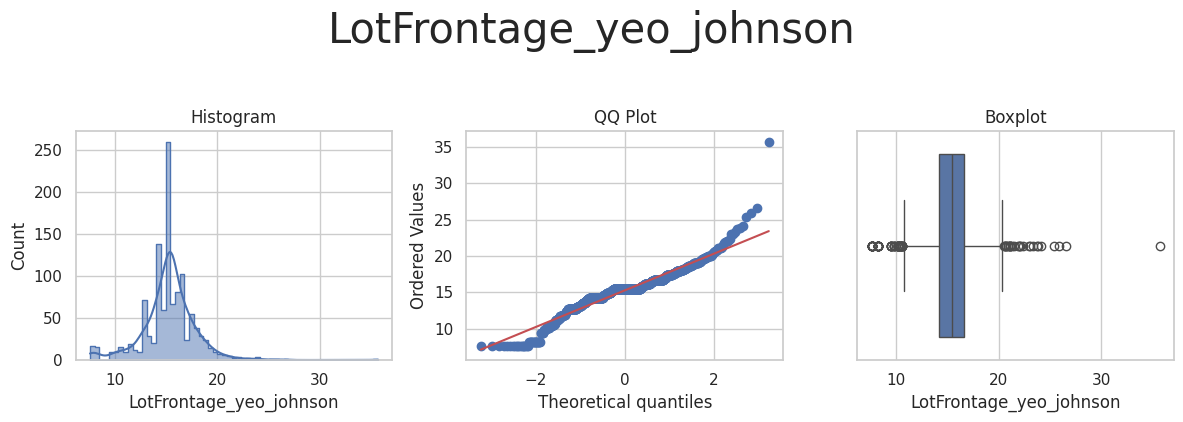



* Variable Analyzed: OpenPorchSF
* Applied transformation: ['OpenPorchSF_power', 'OpenPorchSF_yeo_johnson'] 



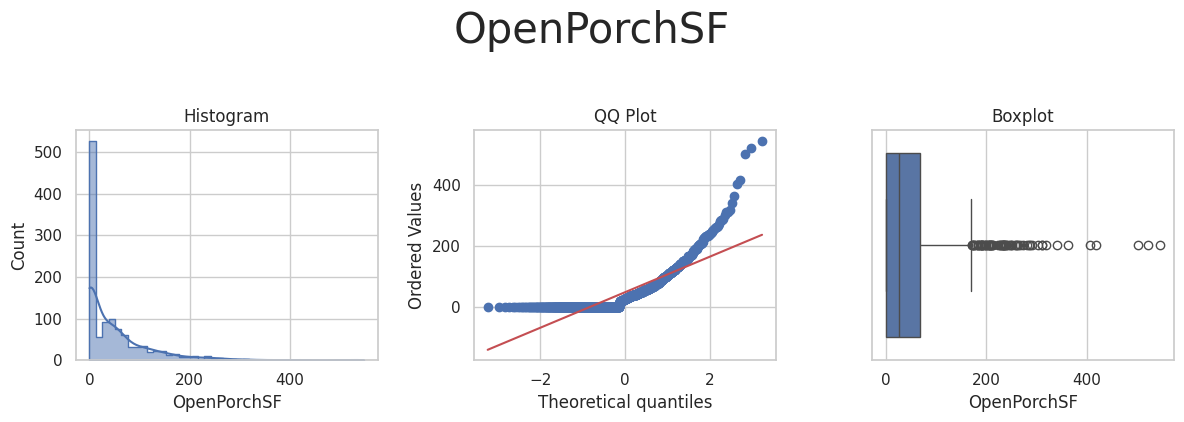

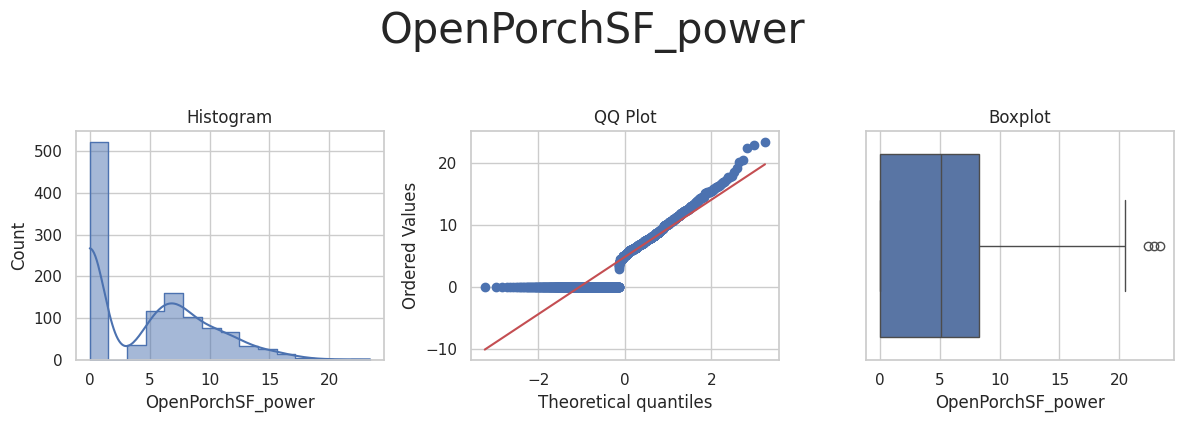

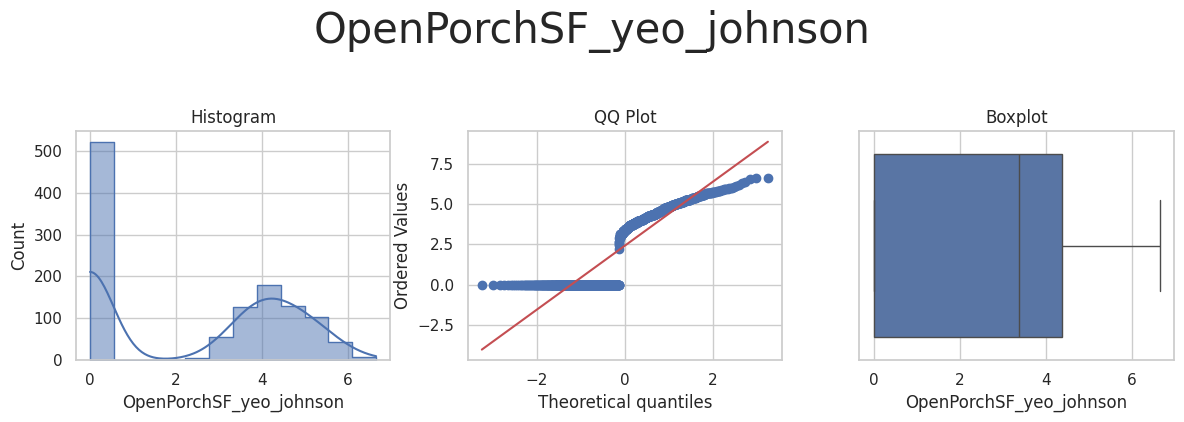



* Variable Analyzed: OverallCond
* Applied transformation: ['OverallCond_log_e', 'OverallCond_log_10', 'OverallCond_reciprocal', 'OverallCond_power', 'OverallCond_box_cox', 'OverallCond_yeo_johnson'] 



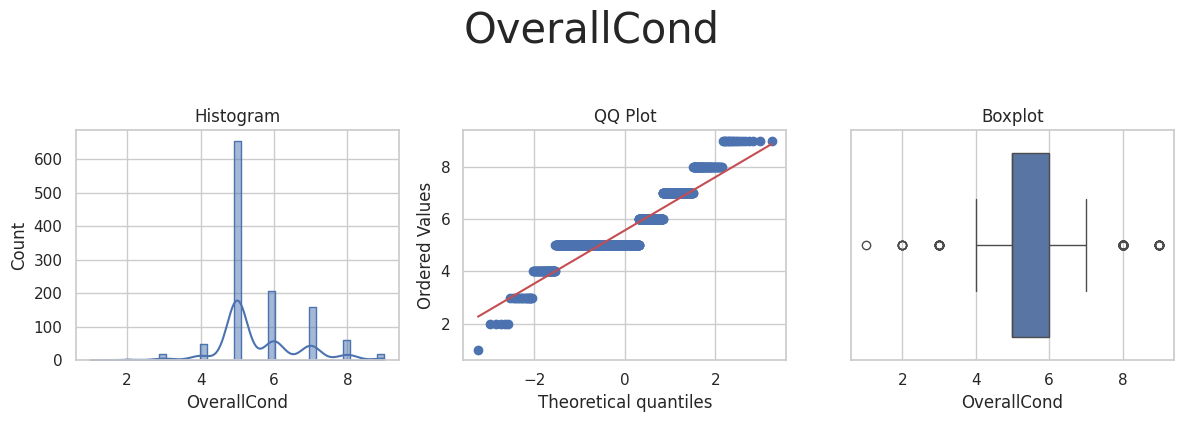

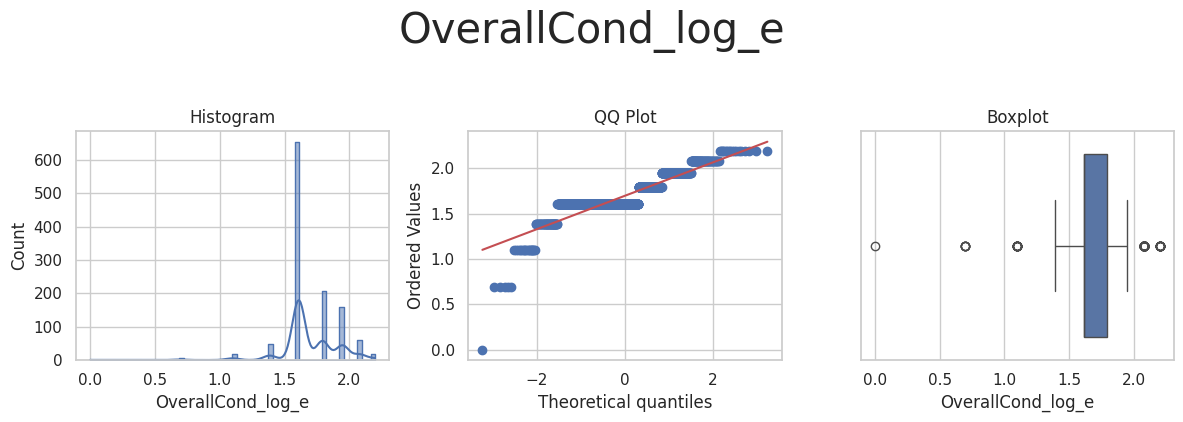

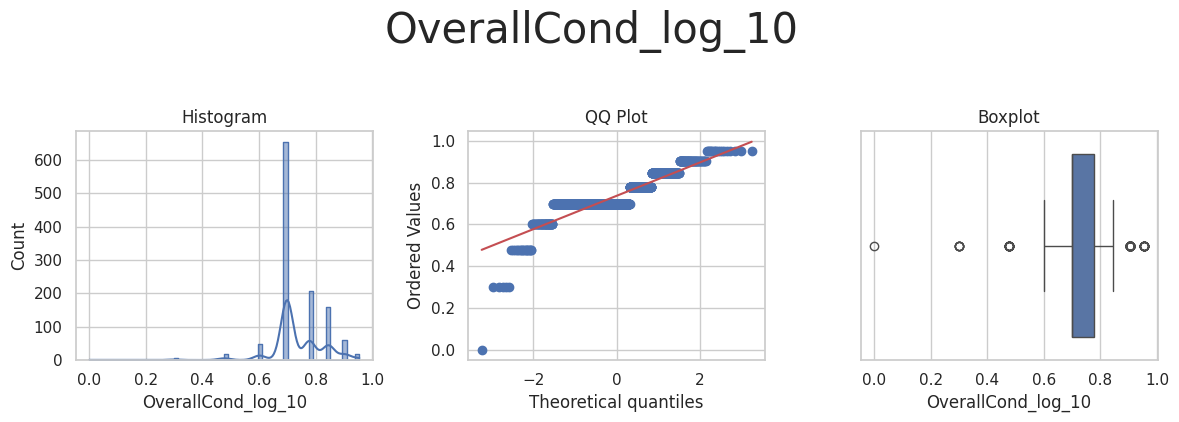

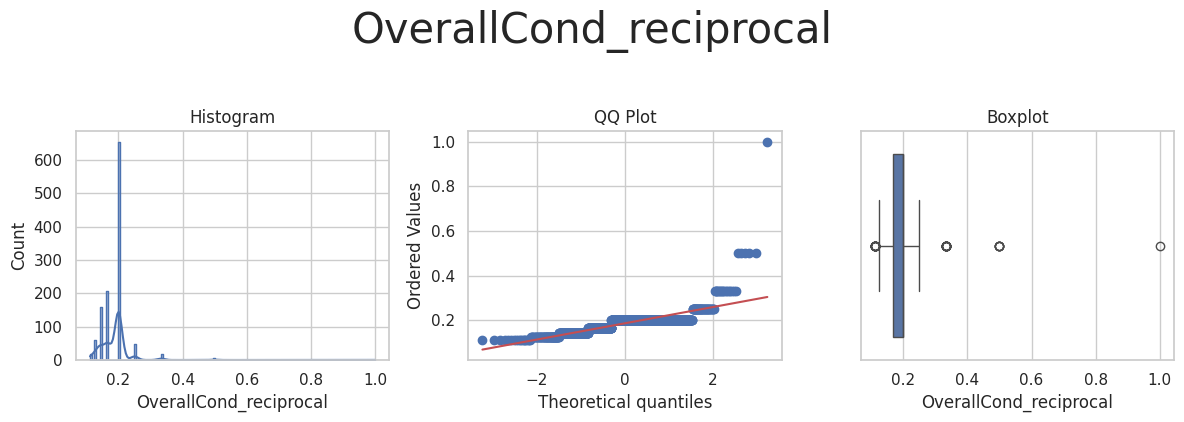

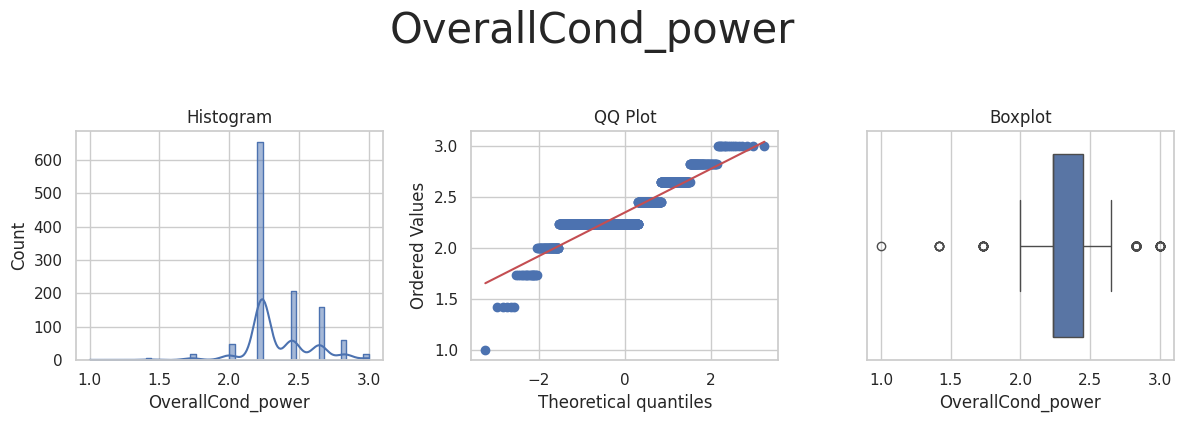

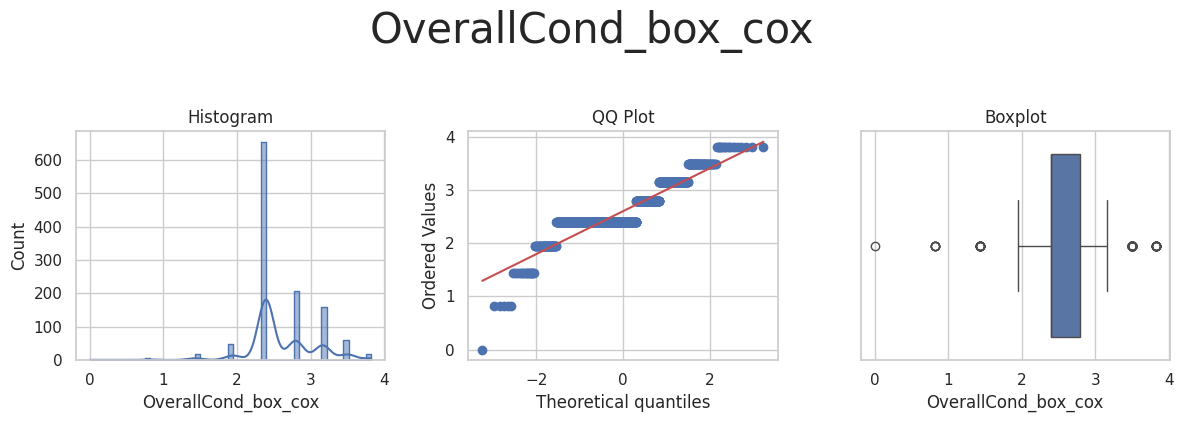

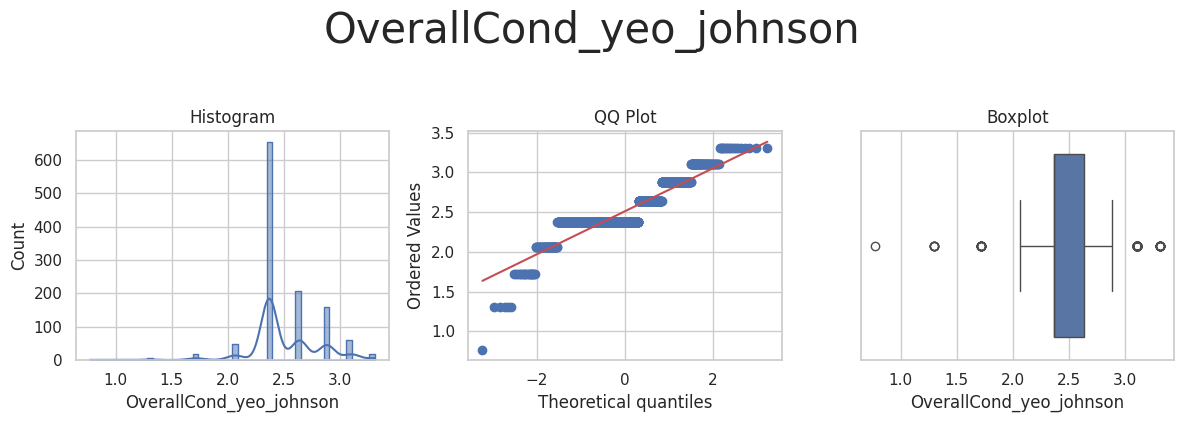



* Variable Analyzed: OverallQual
* Applied transformation: ['OverallQual_log_e', 'OverallQual_log_10', 'OverallQual_reciprocal', 'OverallQual_power', 'OverallQual_box_cox', 'OverallQual_yeo_johnson'] 



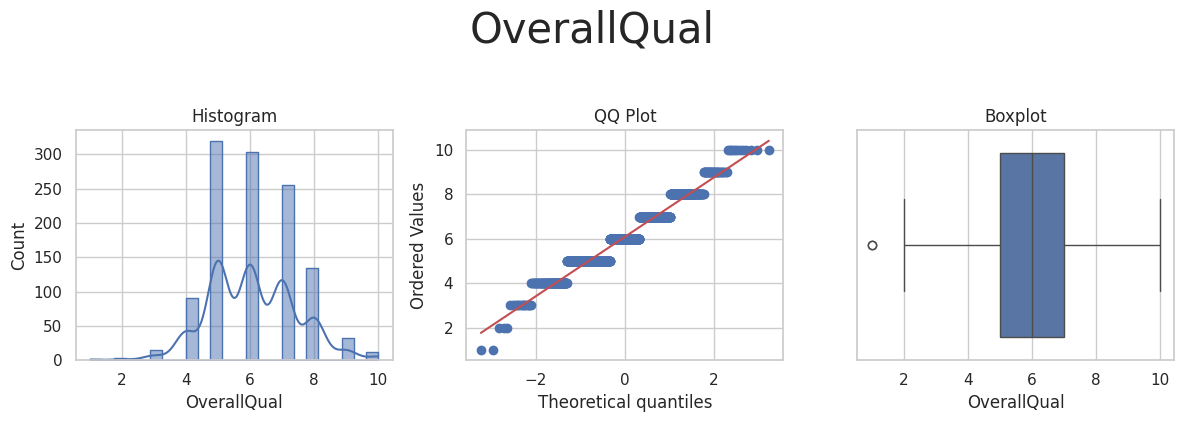

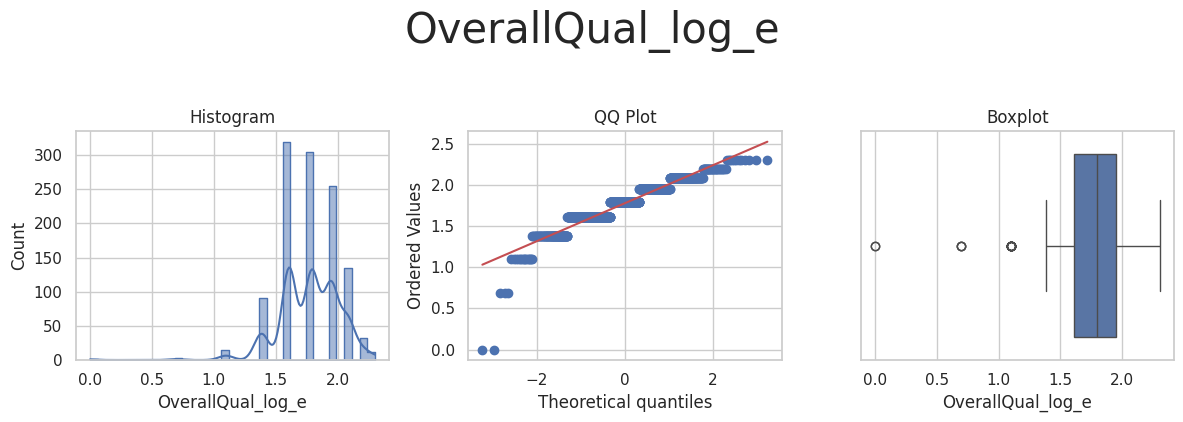

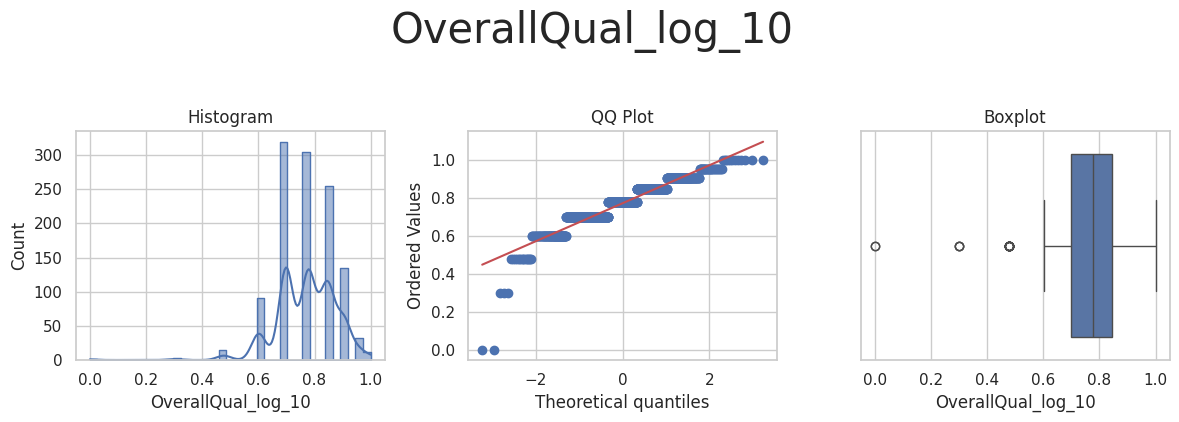

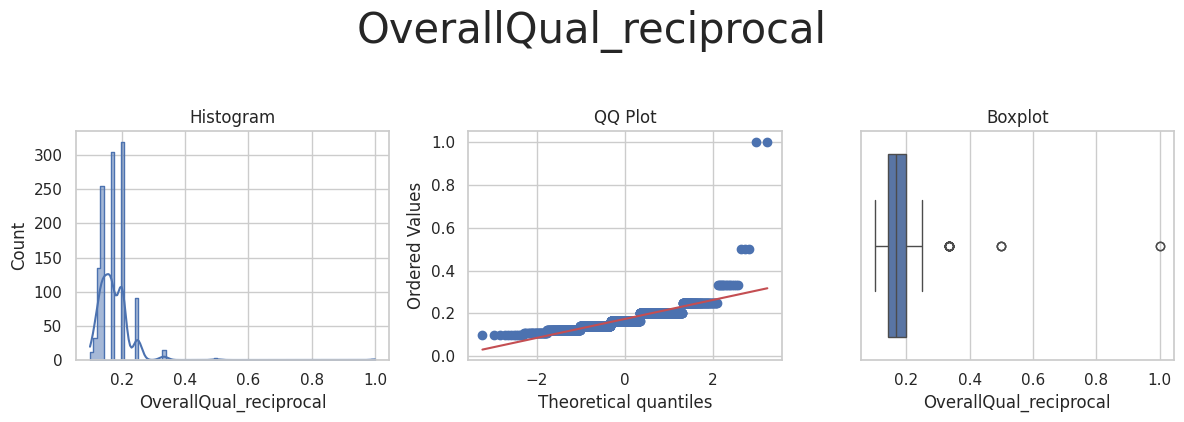

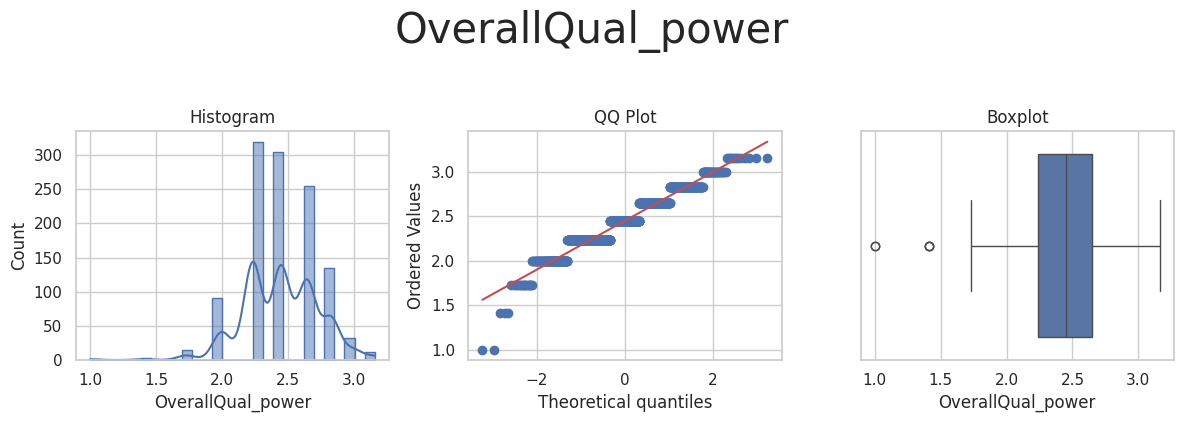

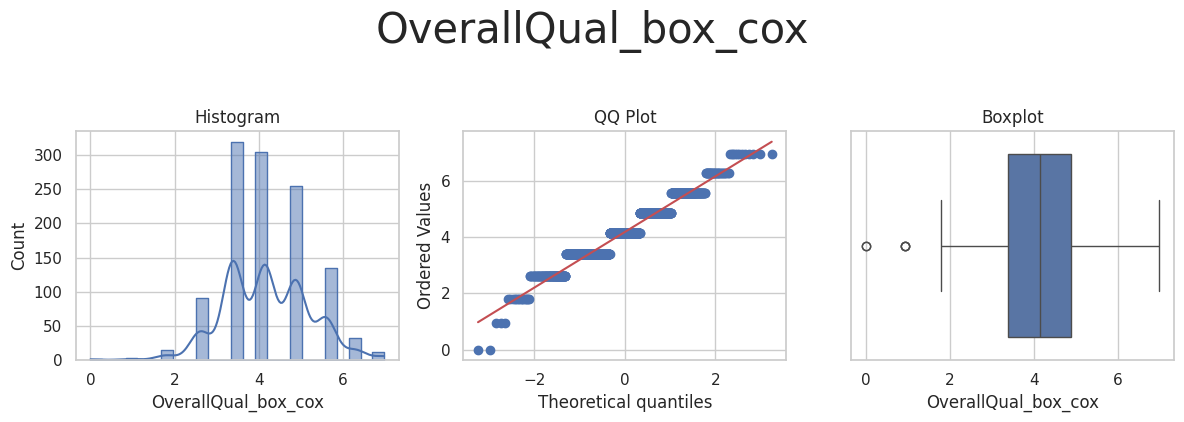

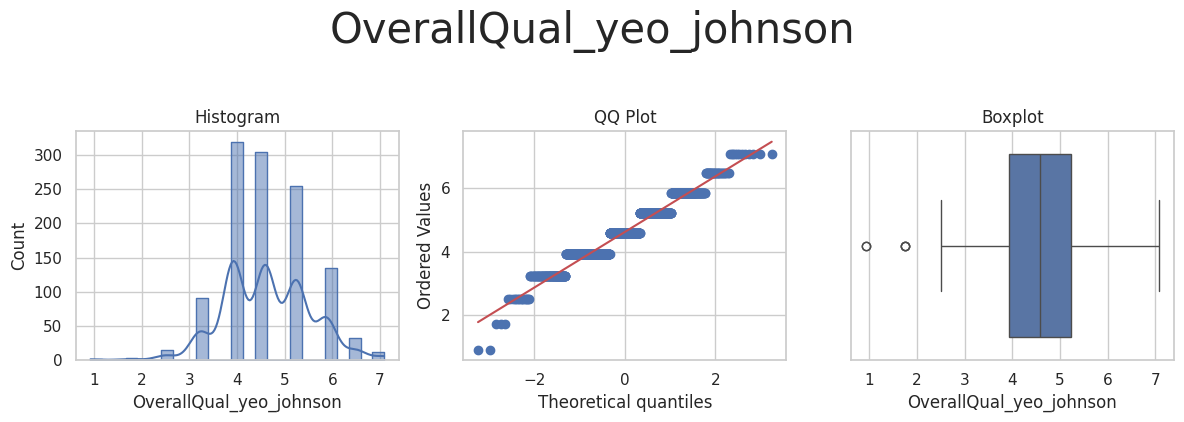



* Variable Analyzed: TotalBsmtSF
* Applied transformation: ['TotalBsmtSF_power', 'TotalBsmtSF_yeo_johnson'] 



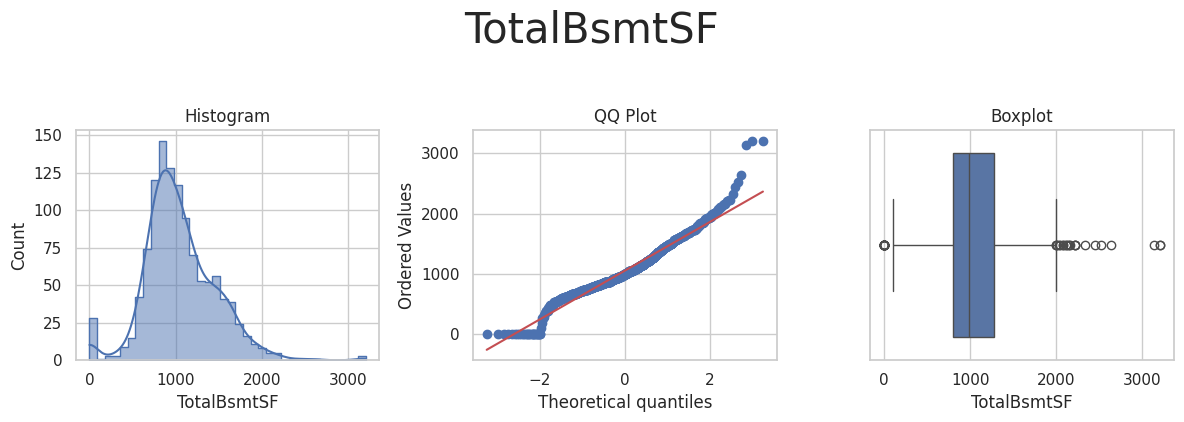

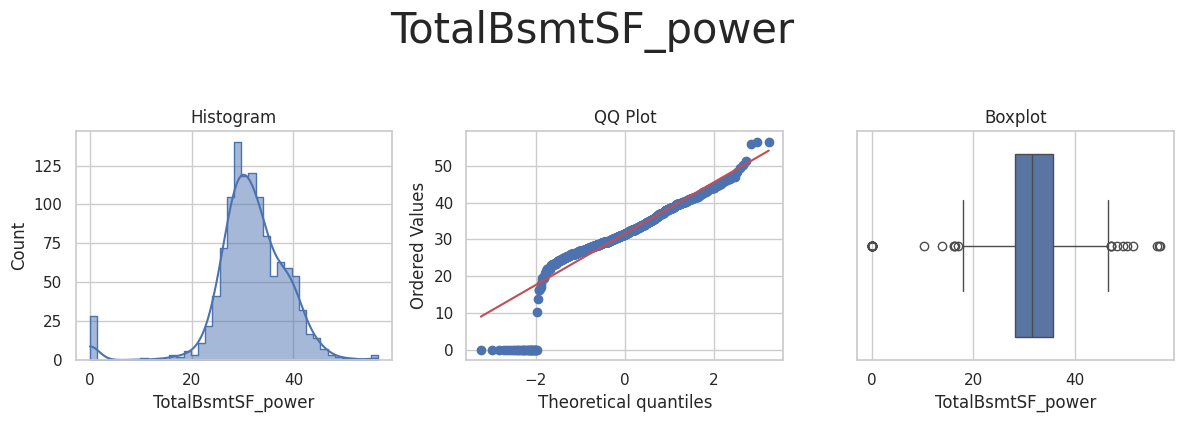

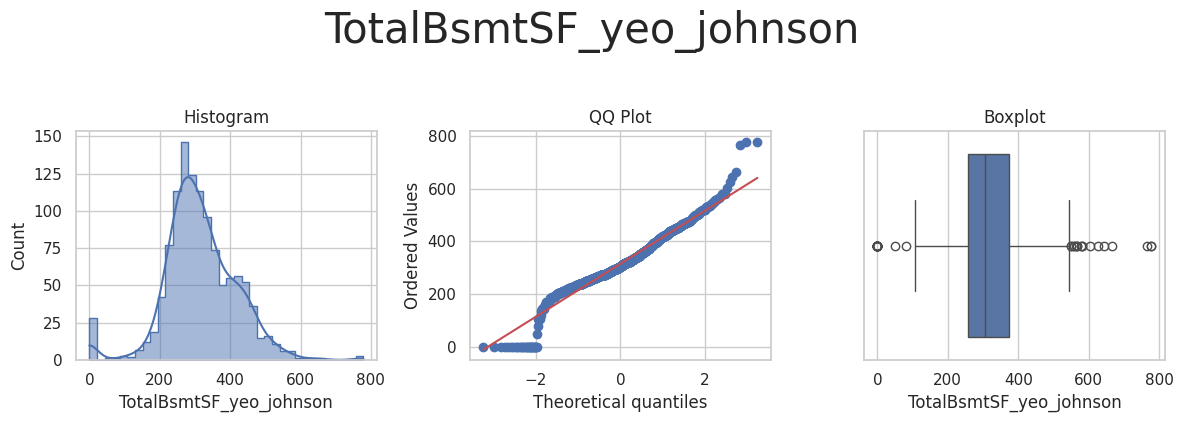



* Variable Analyzed: YearBuilt
* Applied transformation: ['YearBuilt_log_e', 'YearBuilt_log_10', 'YearBuilt_reciprocal', 'YearBuilt_power', 'YearBuilt_box_cox', 'YearBuilt_yeo_johnson'] 



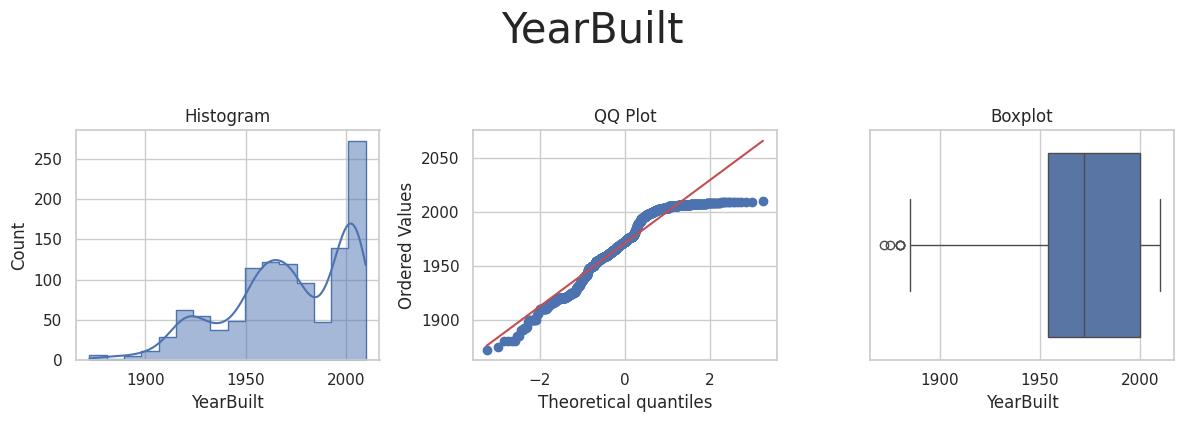

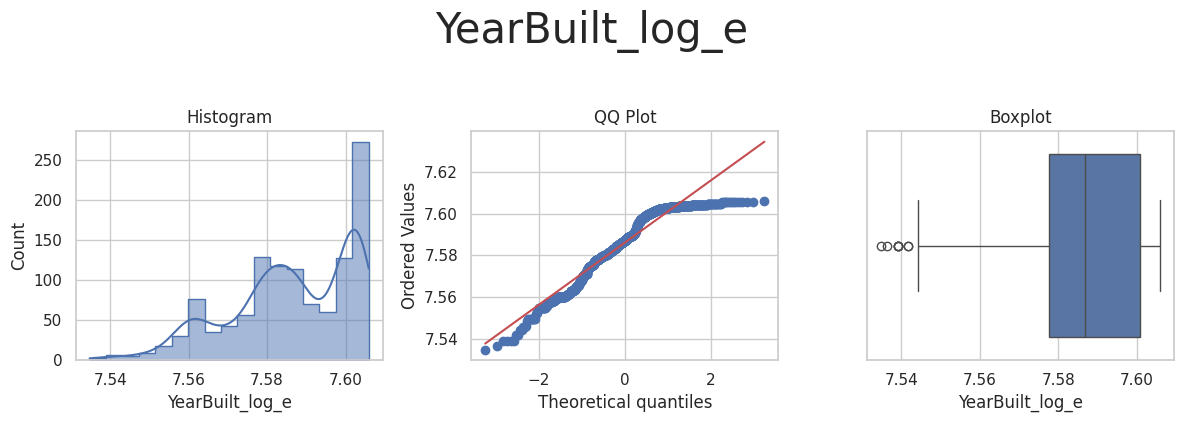

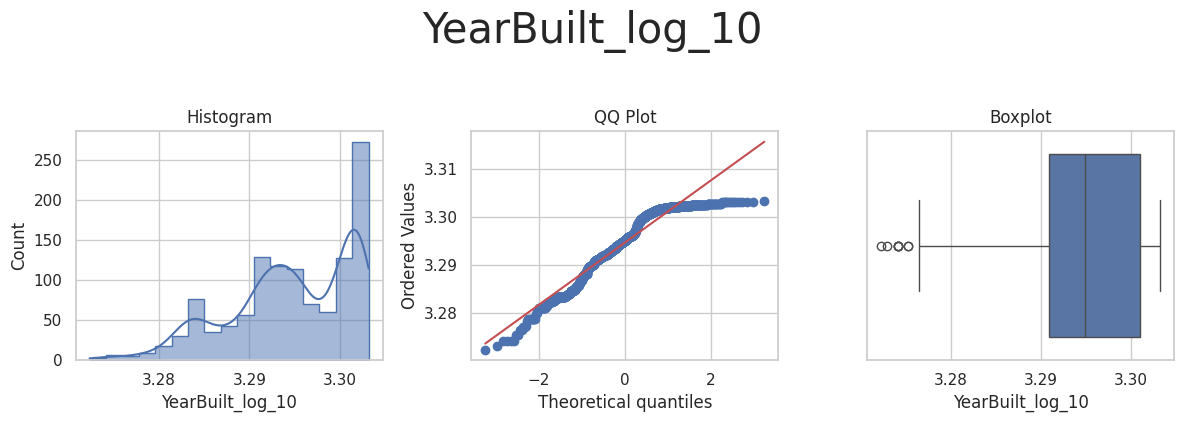

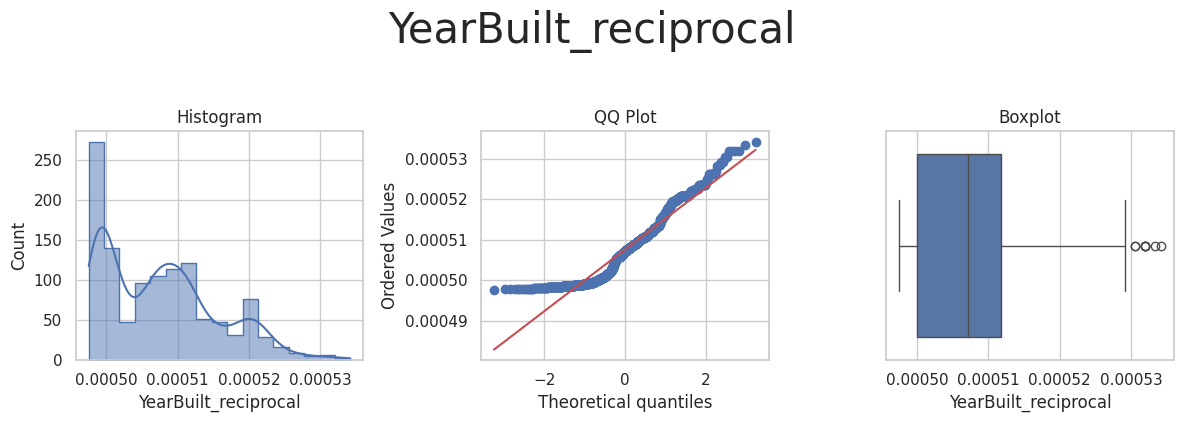

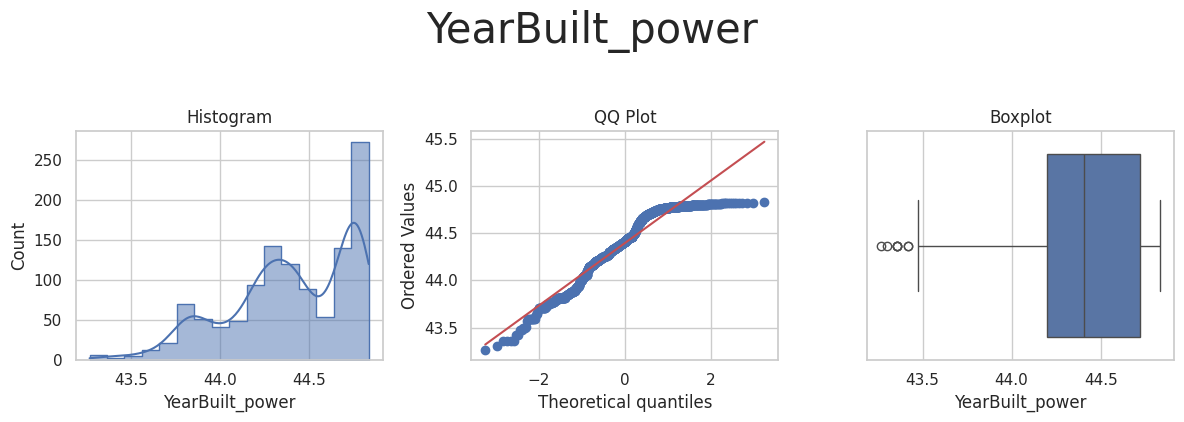

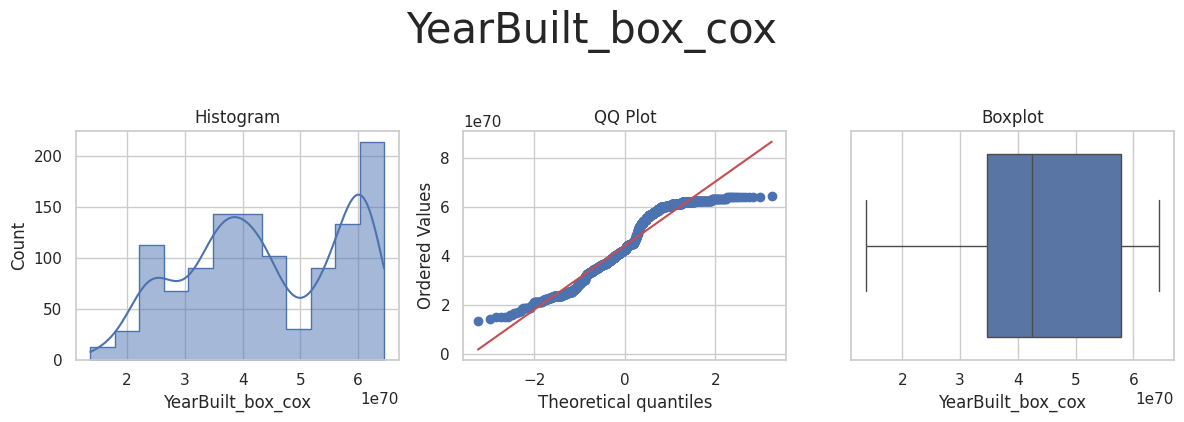

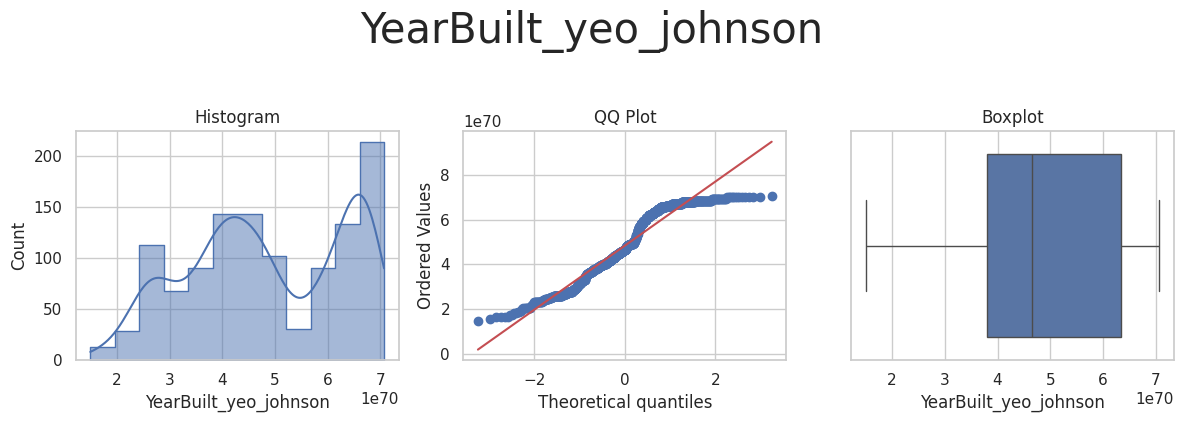



* Variable Analyzed: YearRemodAdd
* Applied transformation: ['YearRemodAdd_log_e', 'YearRemodAdd_log_10', 'YearRemodAdd_reciprocal', 'YearRemodAdd_power', 'YearRemodAdd_box_cox', 'YearRemodAdd_yeo_johnson'] 



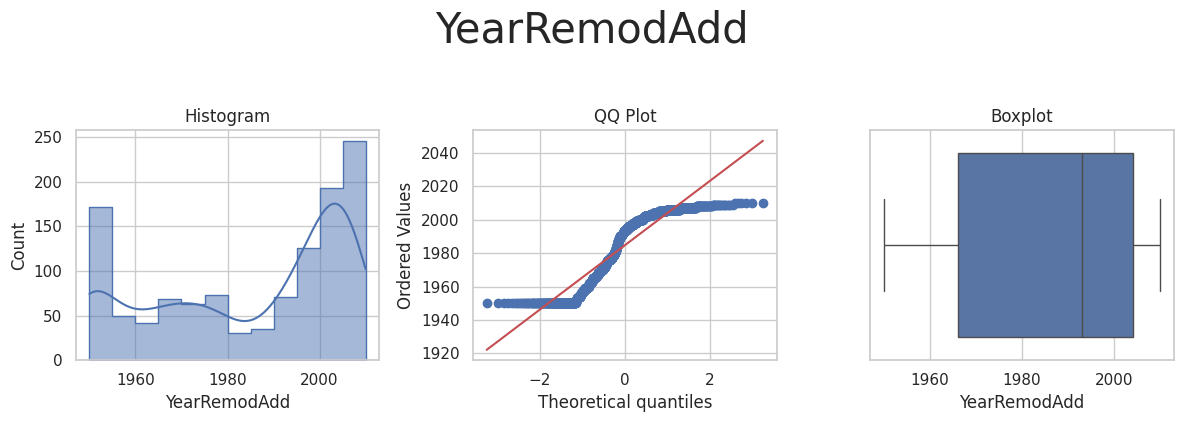

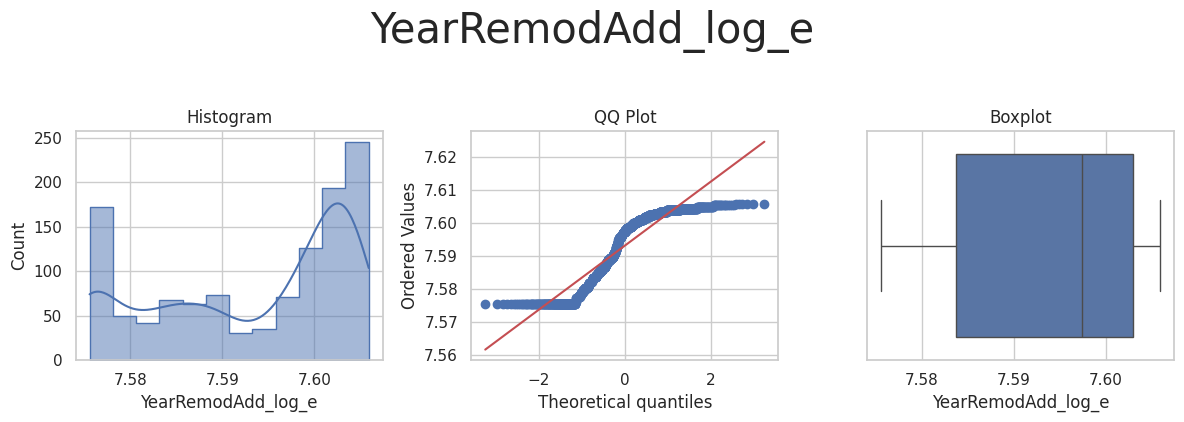

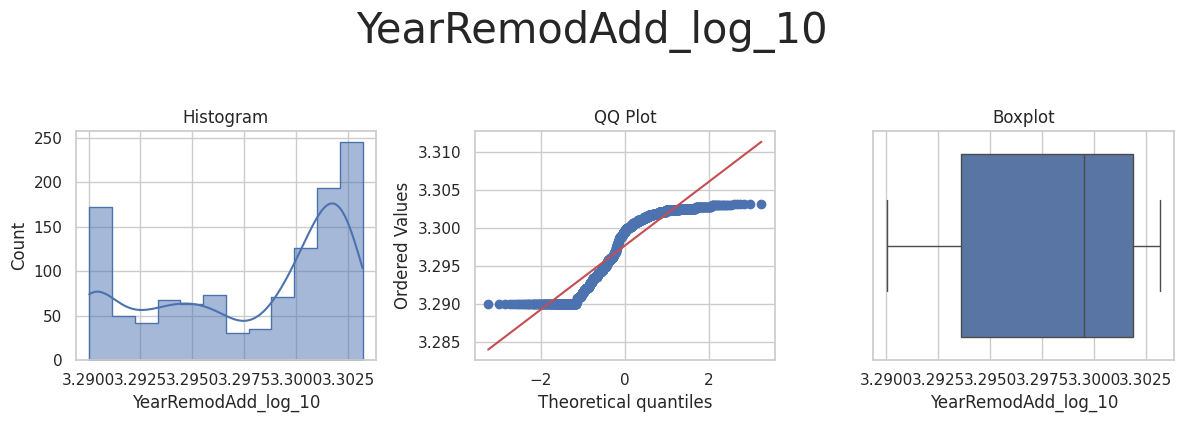

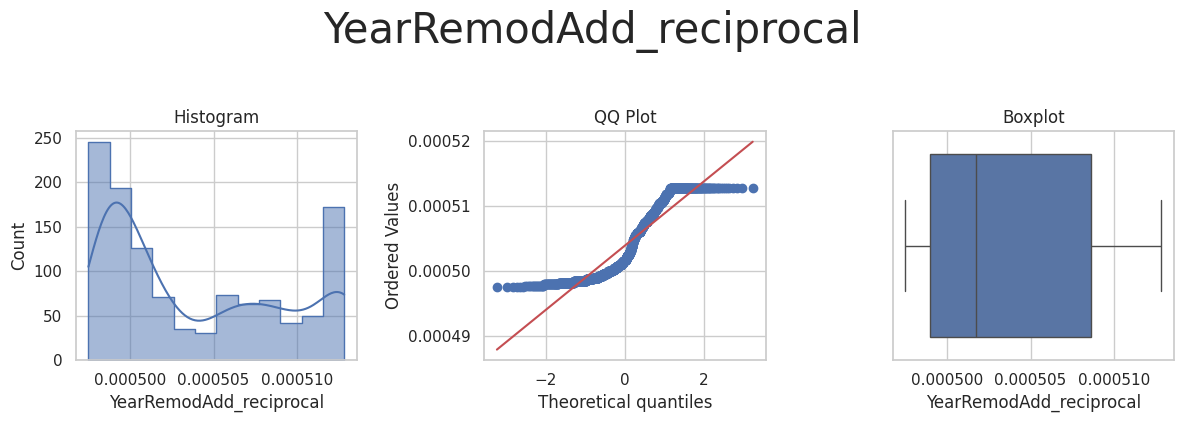

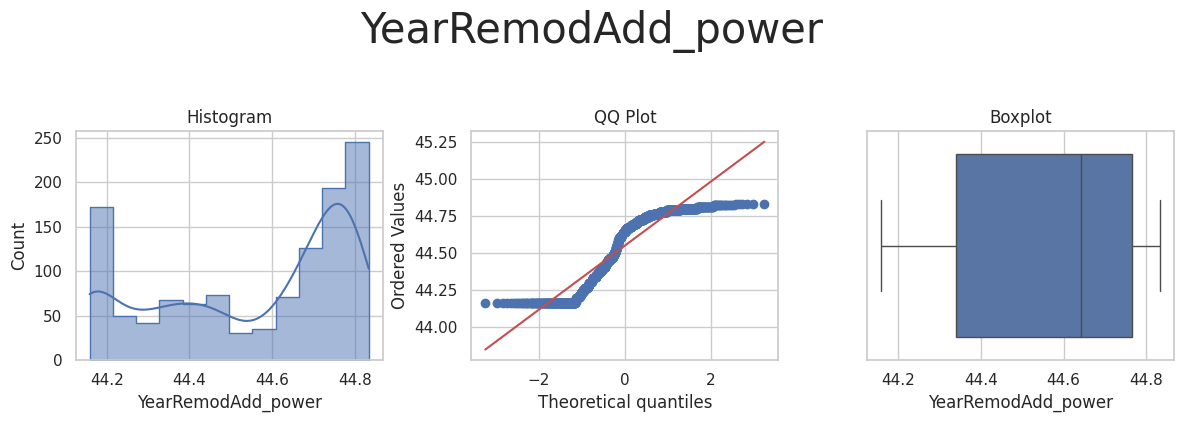

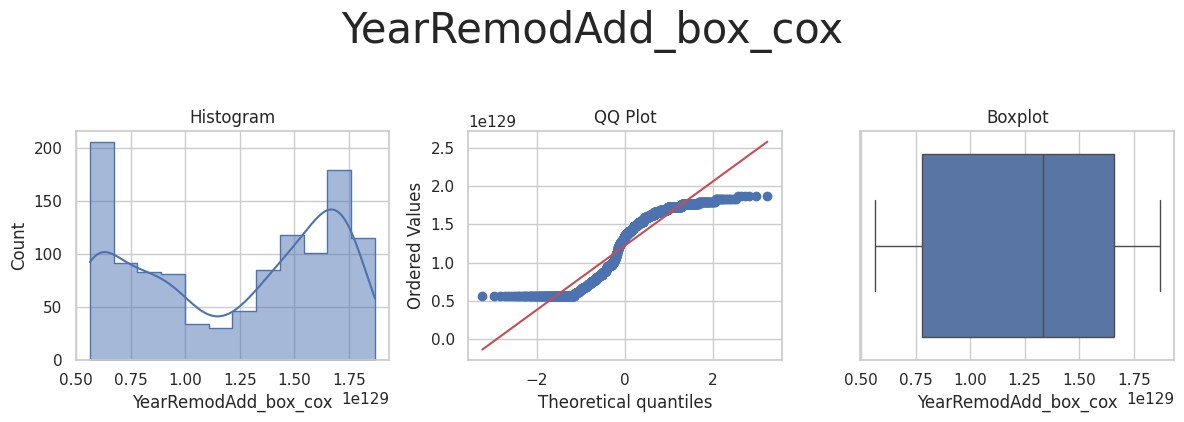

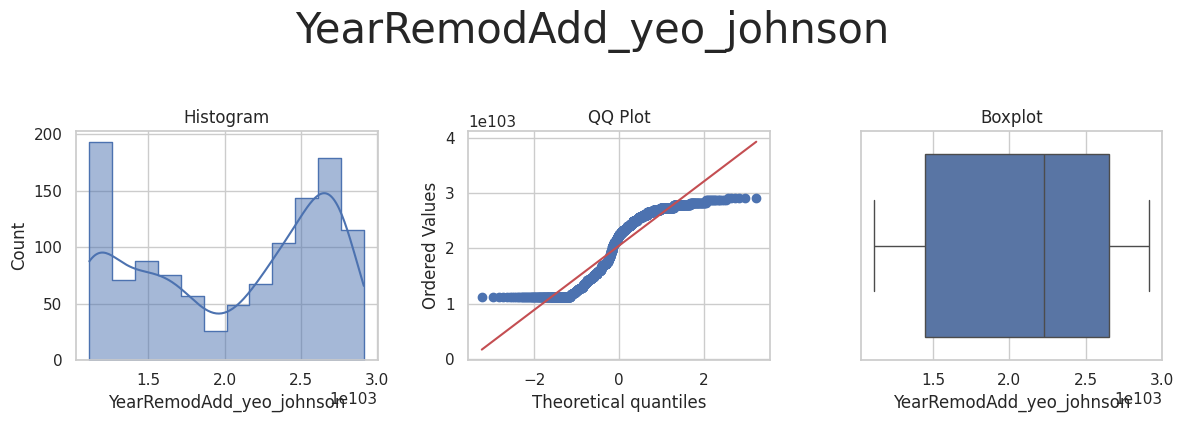



* Variable Analyzed: SalePrice
* Applied transformation: ['SalePrice_log_e', 'SalePrice_log_10', 'SalePrice_reciprocal', 'SalePrice_power', 'SalePrice_box_cox', 'SalePrice_yeo_johnson'] 



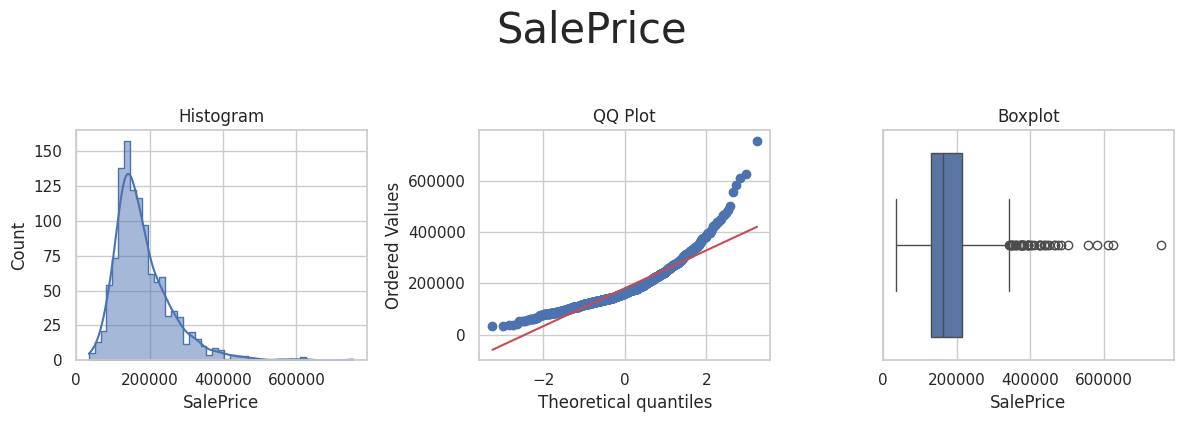

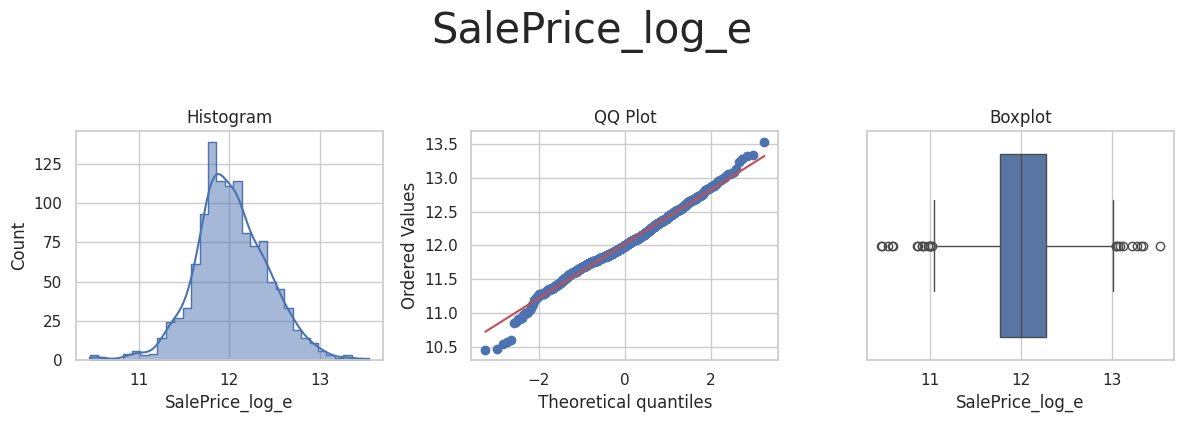

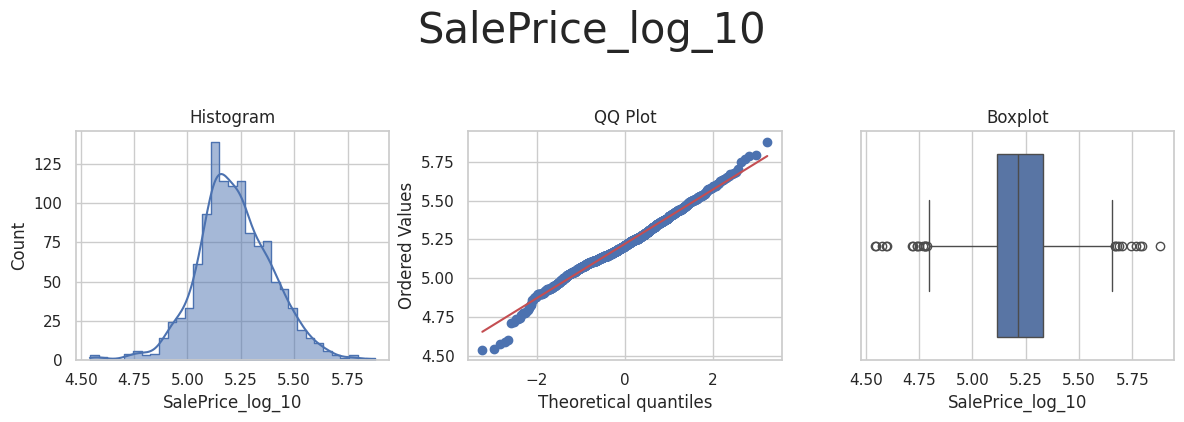

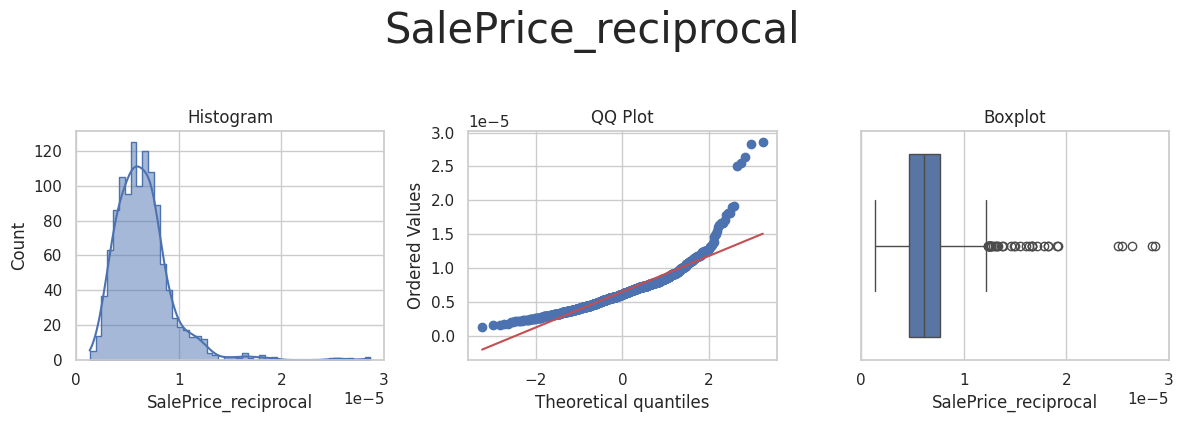

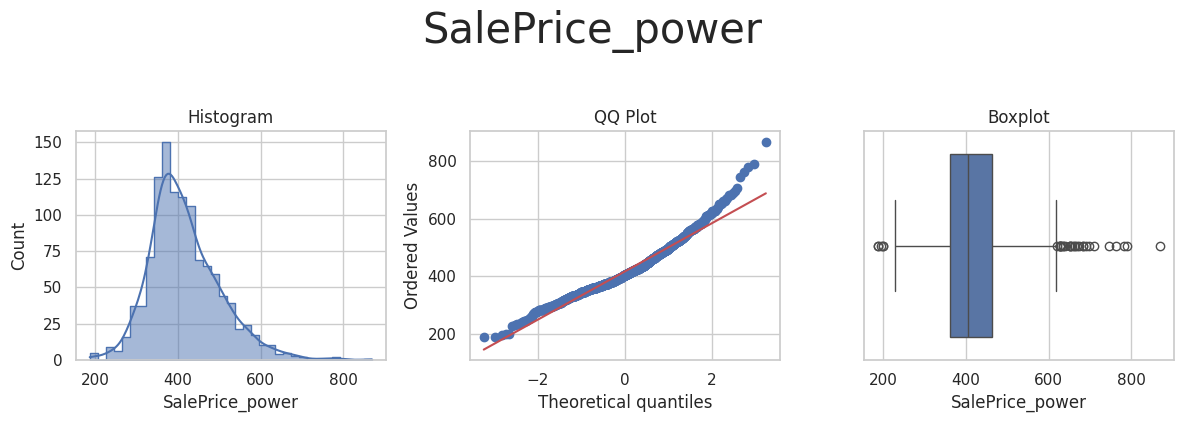

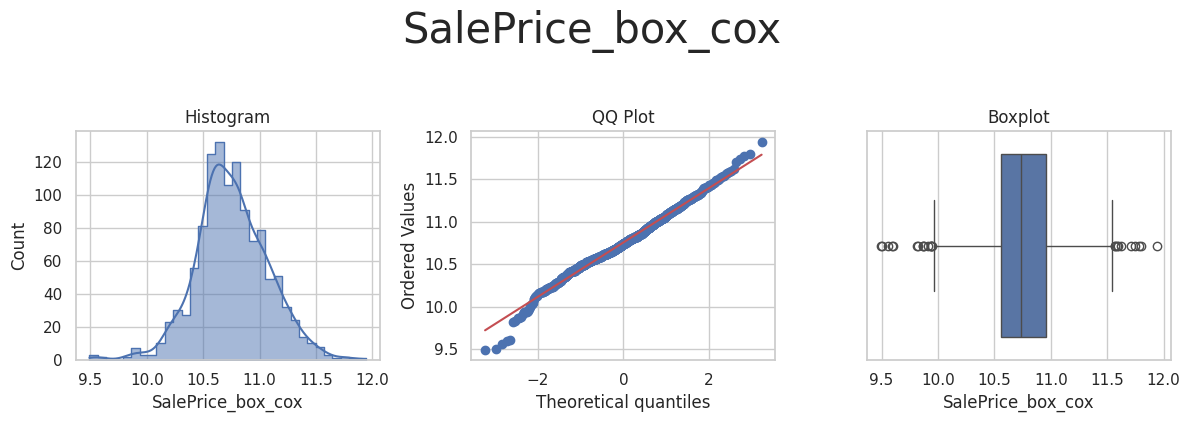

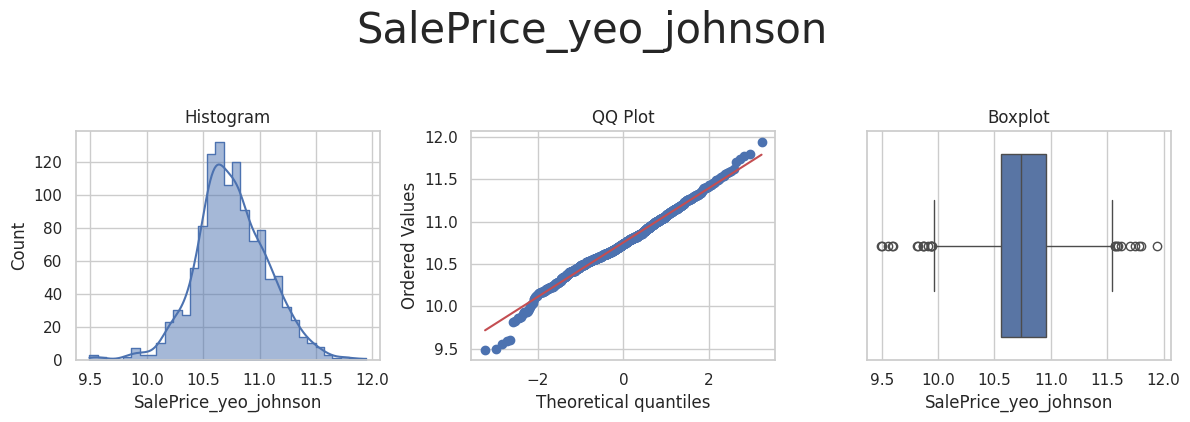

In [14]:

df_numerical_eng = FeatureEngineeringAnalysis(df=df_numeric, analysis_type='numerical')

###  Summary of Variable Transformations and Actions

Based on the visual assessment of distribution plots and diagnostic analyses, the following observations and decisions have been made:

---

### 🔢 **Numerical Variable Transformations**

- **1stFlrSF**: Showed improved distribution with **Log**, **Box-Cox**, and **Yeo-Johnson** transformations. 
- **BsmtUnfSF**: Both **Power** and **Yeo-Johnson** transformations enhanced the distribution.   
- **GrLivArea**: Benefited from **Log**, **Box-Cox**, **Power**, and **Yeo-Johnson** transformations.   
- **LotArea**: Distribution improved using **Log** and **Yeo-Johnson** transformations. 
- **OpenPorchSF**: The **Power** transformation showed the most notable improvement. 
- **TotalBsmtSF**: Responded well to the **Power** transformation. 
- **LotFrontage**: Improved with the **Log** transformation. 
- **SalePrice**: Improved distribution and right skew from **log** transformation. 

**No transformation improvement found** for the following variables, and they will remain unchanged:  
**GarageYrBlt**, **YearBuilt**, **YearRemodAdd**, **OverallCond**, **OverallQual**, **2ndFlrSF**, **BedroomAbvGr**, **BsmtFinSF1**, **GarageArea**

---

### **Categorical Variables – Ordinal Encoding**

The following categorical variables were ordinal by nature and have been encoded accordingly:  
- **BsmtExposure**  
- **BsmtFinType1**  
- **GarageFinish**  
- **KitchenQual**


### Desicions

* **Log transformation:** 1stFlrSF, GrLivArea, LotArea, LotFrontage, SalePrice
*  **Power Transformation:** TotalBsmtSF, OpenPorchSF
*  **Yeo Johnson:** TotalBsmtSF


In [15]:
from feature_engine import transformation as vt
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ("NumericLogTransform",vt.LogTransformer(variables=['1stFlrSF','GrLivArea', 'LotArea','LotFrontage', 'SalePrice'])),
    ("NumericPowerTransform",vt.PowerTransformer(variables=['TotalBsmtSF', 'OpenPorchSF'])),
    ("NumericYeoJohnsonTransform",vt.YeoJohnsonTransformer(variables=['TotalBsmtSF']))
    ])
train_set= pipeline.fit_transform(train_set)
test_set = pipeline.transform(test_set)

print("* The numerical transformation has been completed!")

* The numerical transformation has been completed!


In [16]:
train_set.head()

1stFlrSF  2ndFlrSF  BedroomAbvGr  BsmtExposure  BsmtFinSF1  BsmtFinType1  \
0  7.510978       0.0           0.0             0          48             0   
1  6.795706       0.0           2.0             1           0             0   
2  6.871091       0.0           2.0             1         713             1   
3  7.431892       0.0           3.0             1        1218             2   
4  7.340187       0.0           3.0             1           0             0   

   BsmtUnfSF  GarageArea  GarageFinish  GarageYrBlt  ...  KitchenQual  \
0       1774         774             0       2007.0  ...            0   
1        894         308             0       1962.0  ...            1   
2        163         432             0       1921.0  ...            1   
3        350         857             1       2002.0  ...            0   
4       1541         843             1       2001.0  ...            0   

    LotArea  LotFrontage  OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  \
0  9.366831     4.499810    10.392305            5            9   285.441874   
1  8.794825     4.094345     0.000000            5            5   162.276857   
2  9.500020     4.382027     0.000000            7            5   159.691138   
3  9.492884     4.234107     7.681146            5            8   253.302613   
4  9.525443     4.770685     9.000000            5            7   249.829026   

   YearBuilt  YearRemodAdd  SalePrice  
0       2007          2007  12.659734  
1       1962          1962  11.603680  
2       1921          2006  12.004568  
3       2002          2002  12.509874  
4       2001          2002  12.230765  

[5 rows x 21 columns]

## SmartCorrelatedSelection

Smart Correlated Selection is a feature selection technique used to deal with a situation where multiple variables in your dataset are highly correlated with each other.

First we will create a new dataframe removing our target variable `SalePrice`.

In [21]:
df_no_sale = train_set.drop(['SalePrice'],axis=1)


In [ ]:
df_smart_corr = df_no_sale.copy()

Using the variance selection mathod below - this keeps the variable with the highest variance in each correlated group

In [22]:
from feature_engine.selection import SmartCorrelatedSelection

corr_sel = SmartCorrelatedSelection(variables=None, method='spearman', threshold=0.8, selection_method='variance', missing_values='ignore')

corr_sel.fit_transform(df_smart_corr)
corr_sel.correlated_feature_sets_

[{'1stFlrSF', 'TotalBsmtSF'}, {'GarageYrBlt', 'YearBuilt'}]

In [24]:
corr_sel.features_to_drop_

['1stFlrSF', 'GarageYrBlt']

## Conclusion

**Feature Engineering**

* Log, Power, Box-Cox, and Yeo-Johnson transformations significantly enhanced the distribution shapes of selected numerical features, reducing skewness and improving normality. This is particularly important for building reliable predictive models.

* Variables like 1stFlrSF, GrLivArea, LotArea, OpenPorchSF, and TotalBsmtSF benefited notably from these transformations and will be included in the modeling pipeline in their transformed form.

* Some features, such as GarageYrBlt, YearBuilt, and OverallQual, did not show meaningful improvement after transformation and will be retained in their original form.

* The target variable (SalePrice) also showed improved symmetry and linearity with a log transformation, supporting better model performance.

* Ordinal encoding was appropriately applied to categorical features with inherent order—BsmtExposure, BsmtFinType1, GarageFinish, and KitchenQual—to preserve their meaningful ranking in the modeling process.

In summary, this preprocessing approach ensures that the dataset is statistically sound, well-prepared for modeling, and free from distributional issues that could negatively affect regression performance.

**SmartCorrolatedSelection**

Using Smart Correlated Selection, we identified high correlations between certain variables and made selections based on statistical and structural relevance:

🔹 1stFlrSF was flagged in a highly correlated group. Among similar features (e.g., TotalBsmtSF, GrLivArea), it may have been dropped or retained depending on its lower variance or higher redundancy in capturing the same information as its correlated counterparts.

🔹 GarageYrBlt was also part of a correlated set, likely with YearBuilt or GarageFinish, where one of the variables may have been excluded to reduce multicollinearity and maintain model simplicity.